<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# Imports and Utils

In [30]:
# imports and constants
import json
import pickle
import datetime as dt

import gmaps
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import multiprocessing
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns

from IPython.display import display, HTML
import ipywidgets as widgets

# user imports
from utils.process_data import *
from utils.stats import *
from utils.lifesense_utils import *

%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [31]:
%%javascript
// ToC script
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [32]:
# Code hider, source: http://chris-said.io/2016/02/13/how-to-make-polished-jupyter-presentations-with-optional-code-visibility/
from IPython.display import HTML

HTML('''
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>
''')




# Load Data

In [147]:
baseline_redcap_df = pd.read_excel("data_pull/LS_Wave1_SC_BL_WK1_Data_081419-revised.xlsx",
                            sheet_name=0)

mapping_df = pd.read_csv("data_pull/Wave1LifeSenseEnroll_DATA_LABELS_2019-08-15_0929.csv")

baseline_redcap_dict = dict(zip(mapping_df['Case#:'], mapping_df['LifeSense Study App ID:    ']))

baseline_redcap_df['pid'] = baseline_redcap_df['study_id'].map(baseline_redcap_dict)

def pad_pid(row):
    if len(row['pid']) < 8:
        return ('0' * (8-len(row['pid']))) + row['pid']
    else:
        return row['pid']

baseline_redcap_df['pid'] = baseline_redcap_df['pid'].astype(str)
baseline_redcap_df['pid'] = baseline_redcap_df.apply(pad_pid, axis=1)

age_dict = dict(zip(baseline_redcap_df['pid'], baseline_redcap_df['age']))

In [33]:
state_df = pd.read_pickle("ls_data/state_all.df")
phq_df = pd.read_pickle("ls_data/phq_0_16.df")
cluster_df = pd.read_pickle("ls_data/train_cluster.df").to_frame()
cluster_df = cluster_df.reset_index()

cluster_df['cluster'] = cluster_df['cluster'].map({
    0: 'no_symp',
    1: 'soc_anx',
    2: 'gen_anx',
    3: 'dep_anx'
})

In [34]:
cluster_dict = {k:v for k, v in zip(cluster_df['pid'].values, cluster_df['cluster'].values)}

phq_df = phq_df[phq_df['pid'].isin(cluster_df['pid'])]
phq_df['baseline_cluster'] = phq_df['pid'].map(cluster_dict)

In [35]:
event_dict = {
   "week_0_arm_1": 0,
   "week_1_arm_1": 1,
   "week_4_arm_1": 4,
   "week_7_arm_1": 7,
   "week_10_arm_1": 10,
   "week_13_arm_1": 13,
   "week_16_arm_1": 16
}

phq_df['study_wk'] = phq_df['redcap_event_name'].map(event_dict)

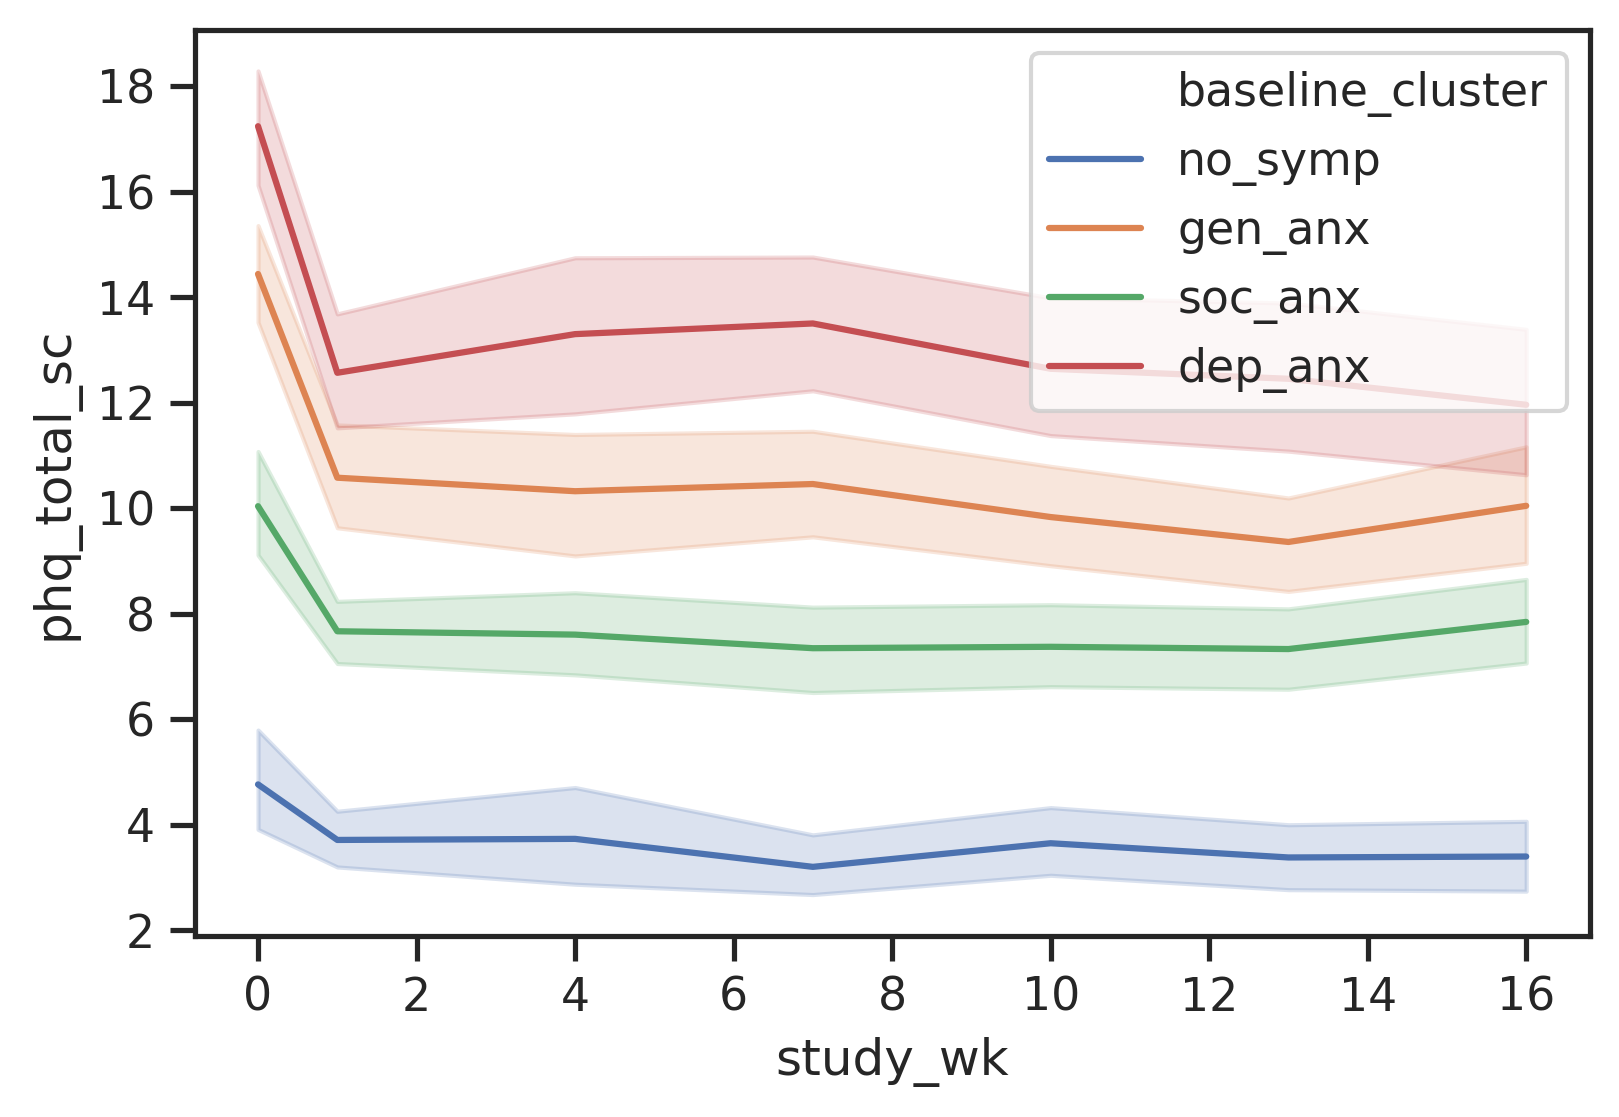

In [44]:
phq_df['phq_start'] = pd.to_datetime(phq_df['phq_start'])
g = sns.lineplot(x="study_wk", y="phq_total_sc", 
                 hue="baseline_cluster", 
                 hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
                            data=phq_df)
plt.legend(loc="upper right")

In [45]:
phq_df['timestamp'] = (phq_df['phq_start'] - dt.datetime(1970,1,1)).dt.total_seconds()

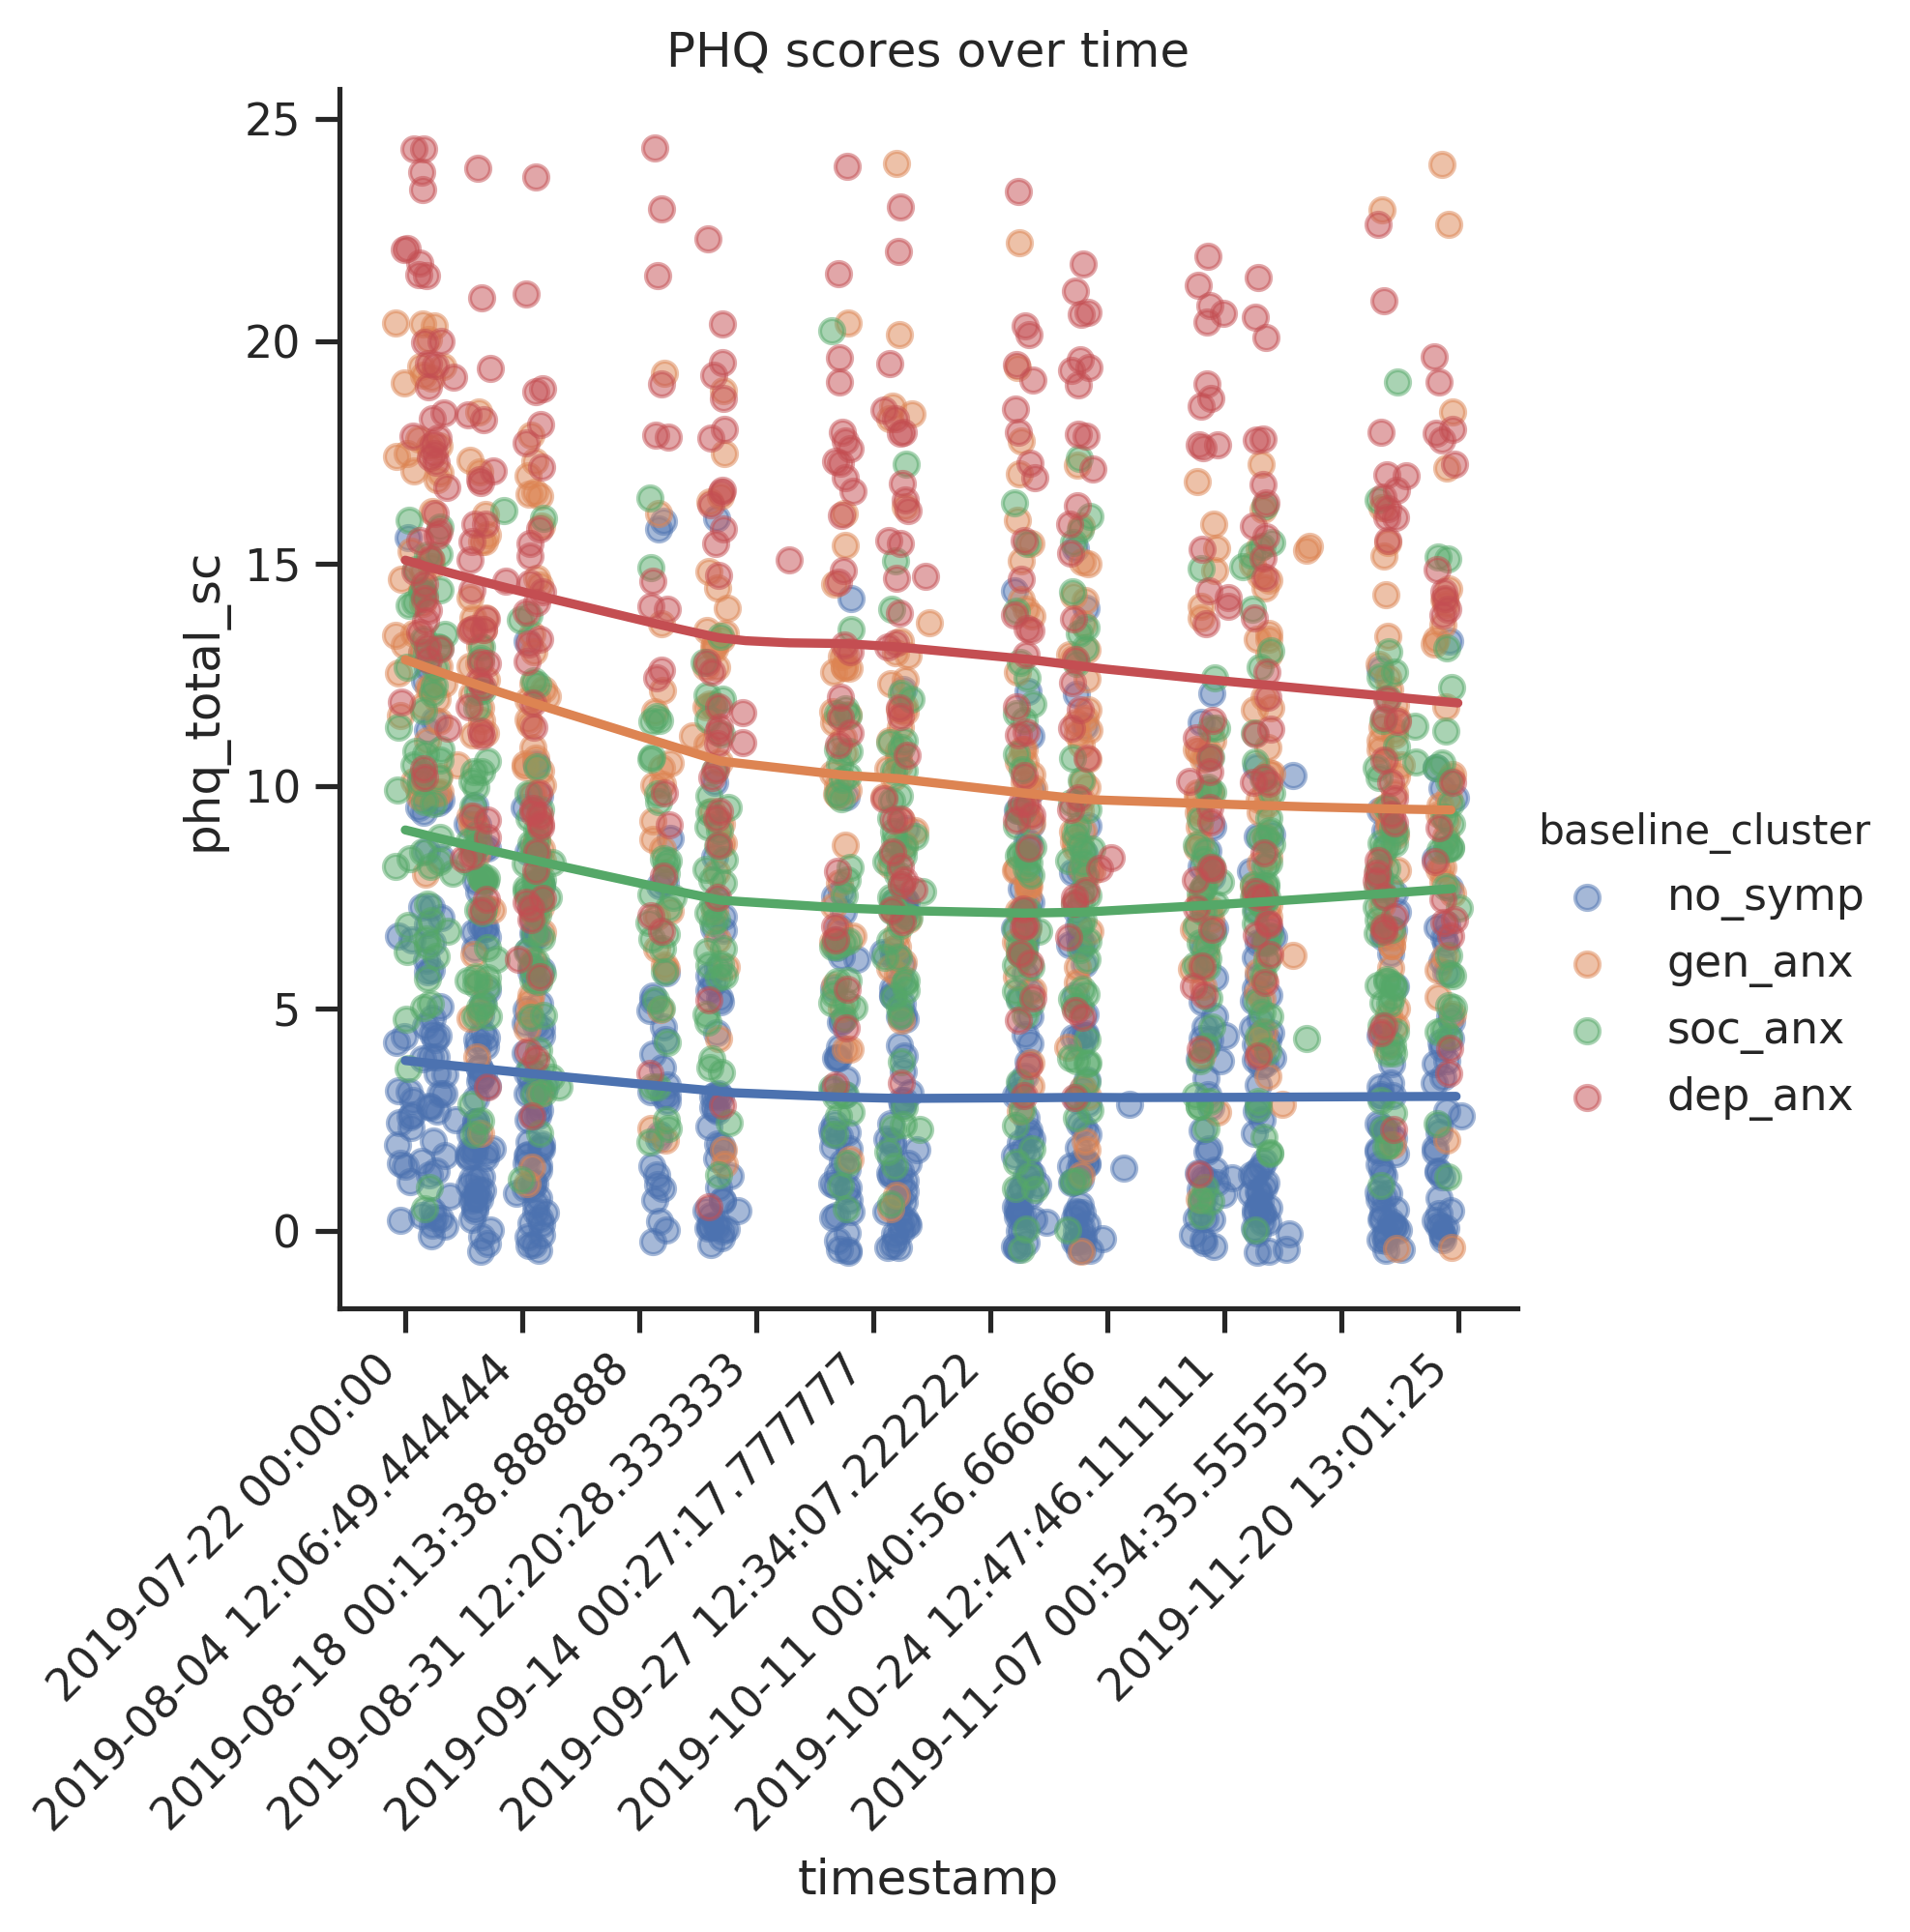

In [47]:
import matplotlib.dates as md


sns.lmplot(x='timestamp', y='phq_total_sc', 
           data=phq_df, 
           lowess=True, 
           hue="baseline_cluster", 
           hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
           x_jitter=100000, y_jitter=0.5,
           scatter_kws = {
               'alpha': 0.5
           },
          )
ax=plt.gca()
ticks = np.linspace(phq_df['timestamp'].min(), phq_df['timestamp'].max(), 10)
idx = pd.date_range(phq_df['phq_start'].min(), phq_df['phq_start'].max(), 10).to_pydatetime()
plt.xticks(ticks, idx, rotation=45, ha='right')
#xfmt = md.DateFormatter('%Y-%m-%d')
#ax.xaxis.set_major_formatter(xfmt)
plt.title("PHQ scores over time")
plt.show()

## Build Sequence DF

In [50]:
phq_df[phq_df['redcap_event_name'] == 'week_1_arm_1']['phq_start'].min()

Timestamp('2019-07-28 08:30:51')

In [51]:
survey_dates = [
    '2019-07-23',
    '2019-07-30',
    '2019-08-05', 
    '2019-08-20',
    '2019-08-26',
    '2019-09-10',
    '2019-09-16',
    '2019-10-01',
    '2019-10-07',
    '2019-10-21',
    '2019-10-29',
    '2019-11-11',
    '2019-11-19'
]

In [53]:
survey_idxs = []
phq_tots = []
phq_dates = []
baseline_clusters = []
pids = []

for pid, group in phq_df.groupby('pid', as_index=False):

    
    for idx, date in enumerate(survey_dates):
        tot = np.nan
        phq_date = np.nan        
        sel_row = group[(group['phq_start'] > (pd.to_datetime(date) - pd.Timedelta(3, unit='D'))) & 
                        (group['phq_start'] < (pd.to_datetime(date) + pd.Timedelta(5, unit='D')))]
        #print(date)
        #display(sel_row)
        if sel_row.shape[0] > 0:
            tot = sel_row['phq_total_sc'].values[0]
            phq_date = sel_row['phq_start'].values[0]
            
        phq_tots.append(tot)
        phq_dates.append(phq_date)
        baseline_clusters.append(group['baseline_cluster'].values[0])
        pids.append(pid)
        survey_idxs.append(idx)

In [55]:
phq_seq_df = pd.DataFrame()
phq_seq_df['pid'] = pids
phq_seq_df['baseline_cluster'] = baseline_clusters
phq_seq_df['survey_idx'] = survey_idxs
phq_seq_df['date'] = phq_dates
phq_seq_df['phq_tot'] = phq_tots

In [61]:
color_map = {
    'no_symp': 'blue',
    'gen_anx': 'orange',
    'soc_anx': 'green',
    'dep_anx': 'red'
}

In [62]:
phq_pivot = phq_seq_df.pivot_table(index="pid", columns=['survey_idx'])

# need better imputation
phq_pivot = phq_pivot.T.fillna(phq_pivot.mean(axis=1)).T

In [63]:
print(color_map)

{'no_symp': 'blue', 'gen_anx': 'orange', 'soc_anx': 'green', 'dep_anx': 'red'}


In [70]:
phq_pivot

phq_tot                                                         \
survey_idx      0          1          2          3          4          5    
pid                                                                         
00746649      12.0  13.000000   7.000000   9.818182   9.000000  12.000000   
01225297      10.0   7.000000  10.000000   8.000000   8.000000   8.000000   
01254121       0.0   1.000000   1.000000   0.000000   0.000000   0.750000   
01495950      15.0   8.000000   5.000000   6.000000   8.000000  12.000000   
01766910      12.0  13.000000  13.000000  12.000000  12.000000  12.000000   
02970060      12.0  13.000000  12.000000   7.000000   6.000000   6.000000   
03233601      14.0  12.000000  16.000000  13.500000  13.000000  13.500000   
03578019      12.0   2.000000   5.000000   6.777778   9.000000   7.000000   
03939827       6.0   8.000000   8.000000   4.000000   4.000000   3.000000   
04133537      15.0   9.000000   9.000000  19.000000  13.000000  20.000000   
04918121      13.0   6.000000   9.363636   7.000000   9.363636  10.000000   
06400675      15.0  16.000000  15.000000  12.083333  15.000000  15.000000   
06638392      14.0  17.000000  15.000000  15.000000  14.400000  12.000000   
07974290      11.0   7.000000   9.666667   9.666667   9.666667  10.000000   
08007167      11.0   9.000000  10.000000   4.000000   8.000000   7.333333   
08103884      15.0  11.000000   9.000000   9.900000   9.000000   9.900000   
09489685      13.0   4.625000   3.000000   4.625000   1.000000   4.625000   
09611865      19.0  14.000000  15.000000  10.000000  15.000000  22.000000   
10099555      22.0  14.000000  21.000000  21.000000  19.000000  15.000000   
10285142      13.0  13.000000  11.000000  13.636364  12.000000  13.000000   
11770862       0.0   1.000000   0.000000   0.428571   1.000000   0.428571   
11927637       1.0   3.000000   2.000000   2.000000   7.000000   3.000000   
12807049      12.0  14.000000   7.000000  12.888889  11.000000  12.888889   
13051775       8.0   4.777778   4.000000   3.000000   4.777778   6.000000   
13250317      14.0  12.000000  13.000000  14.000000  20.000000  19.000000   
14113160      11.0   8.000000   9.000000  11.000000  11.000000   2.000000   
14196469      12.0   5.000000   7.000000   8.000000   8.000000   8.000000   
14549710      17.0  16.000000  14.000000  15.272727  13.000000  16.000000   
14753485       5.0   7.000000   4.000000   4.090909   2.000000  10.000000   
16777771       8.0   5.000000   3.000000   3.909091   3.909091   5.000000   
...            ...        ...        ...        ...        ...        ...   
81720300       5.0   5.000000   7.000000   5.000000   6.000000   6.000000   
81729157       1.0   1.000000   3.000000   2.000000   5.000000   2.833333   
82727218      13.0   8.000000  10.000000   8.000000   5.000000   7.000000   
83056303      14.0   9.166667  11.000000  10.000000   9.000000   7.000000   
83085276       7.0   6.000000   5.250000   5.250000   5.250000   6.000000   
83275234      16.0   9.000000   6.000000   7.400000   7.400000   7.400000   
84877086      13.0   8.833333   8.833333   8.833333   8.833333   8.833333   
84902402      10.0   4.000000   1.000000   6.000000   6.000000   7.333333   
85752121       4.0   4.000000   2.000000   2.111111   3.000000   2.111111   
86283726      10.0   5.833333   5.833333   5.833333   5.833333   5.833333   
86756971       6.0   4.000000   3.000000   5.000000   7.000000   2.000000   
87400142       5.0   2.000000   1.000000   2.000000   2.000000   1.818182   
87485171       4.0   7.000000   5.000000   5.181818   3.000000   5.181818   
89057862       7.0   4.000000   1.000000   0.000000   1.000000   1.000000   
89434074      10.0   6.000000   1.000000   2.000000   1.000000   2.000000   
90229239      11.0  11.000000   9.000000  10.714286   7.000000  10.714286   
90587846       2.0   6.250000   5.000000   5.000000   6.000000  14.000000   
90638927      13.0   8.636364   8.000000   8.000000   8.000000  11.000000   
9076383

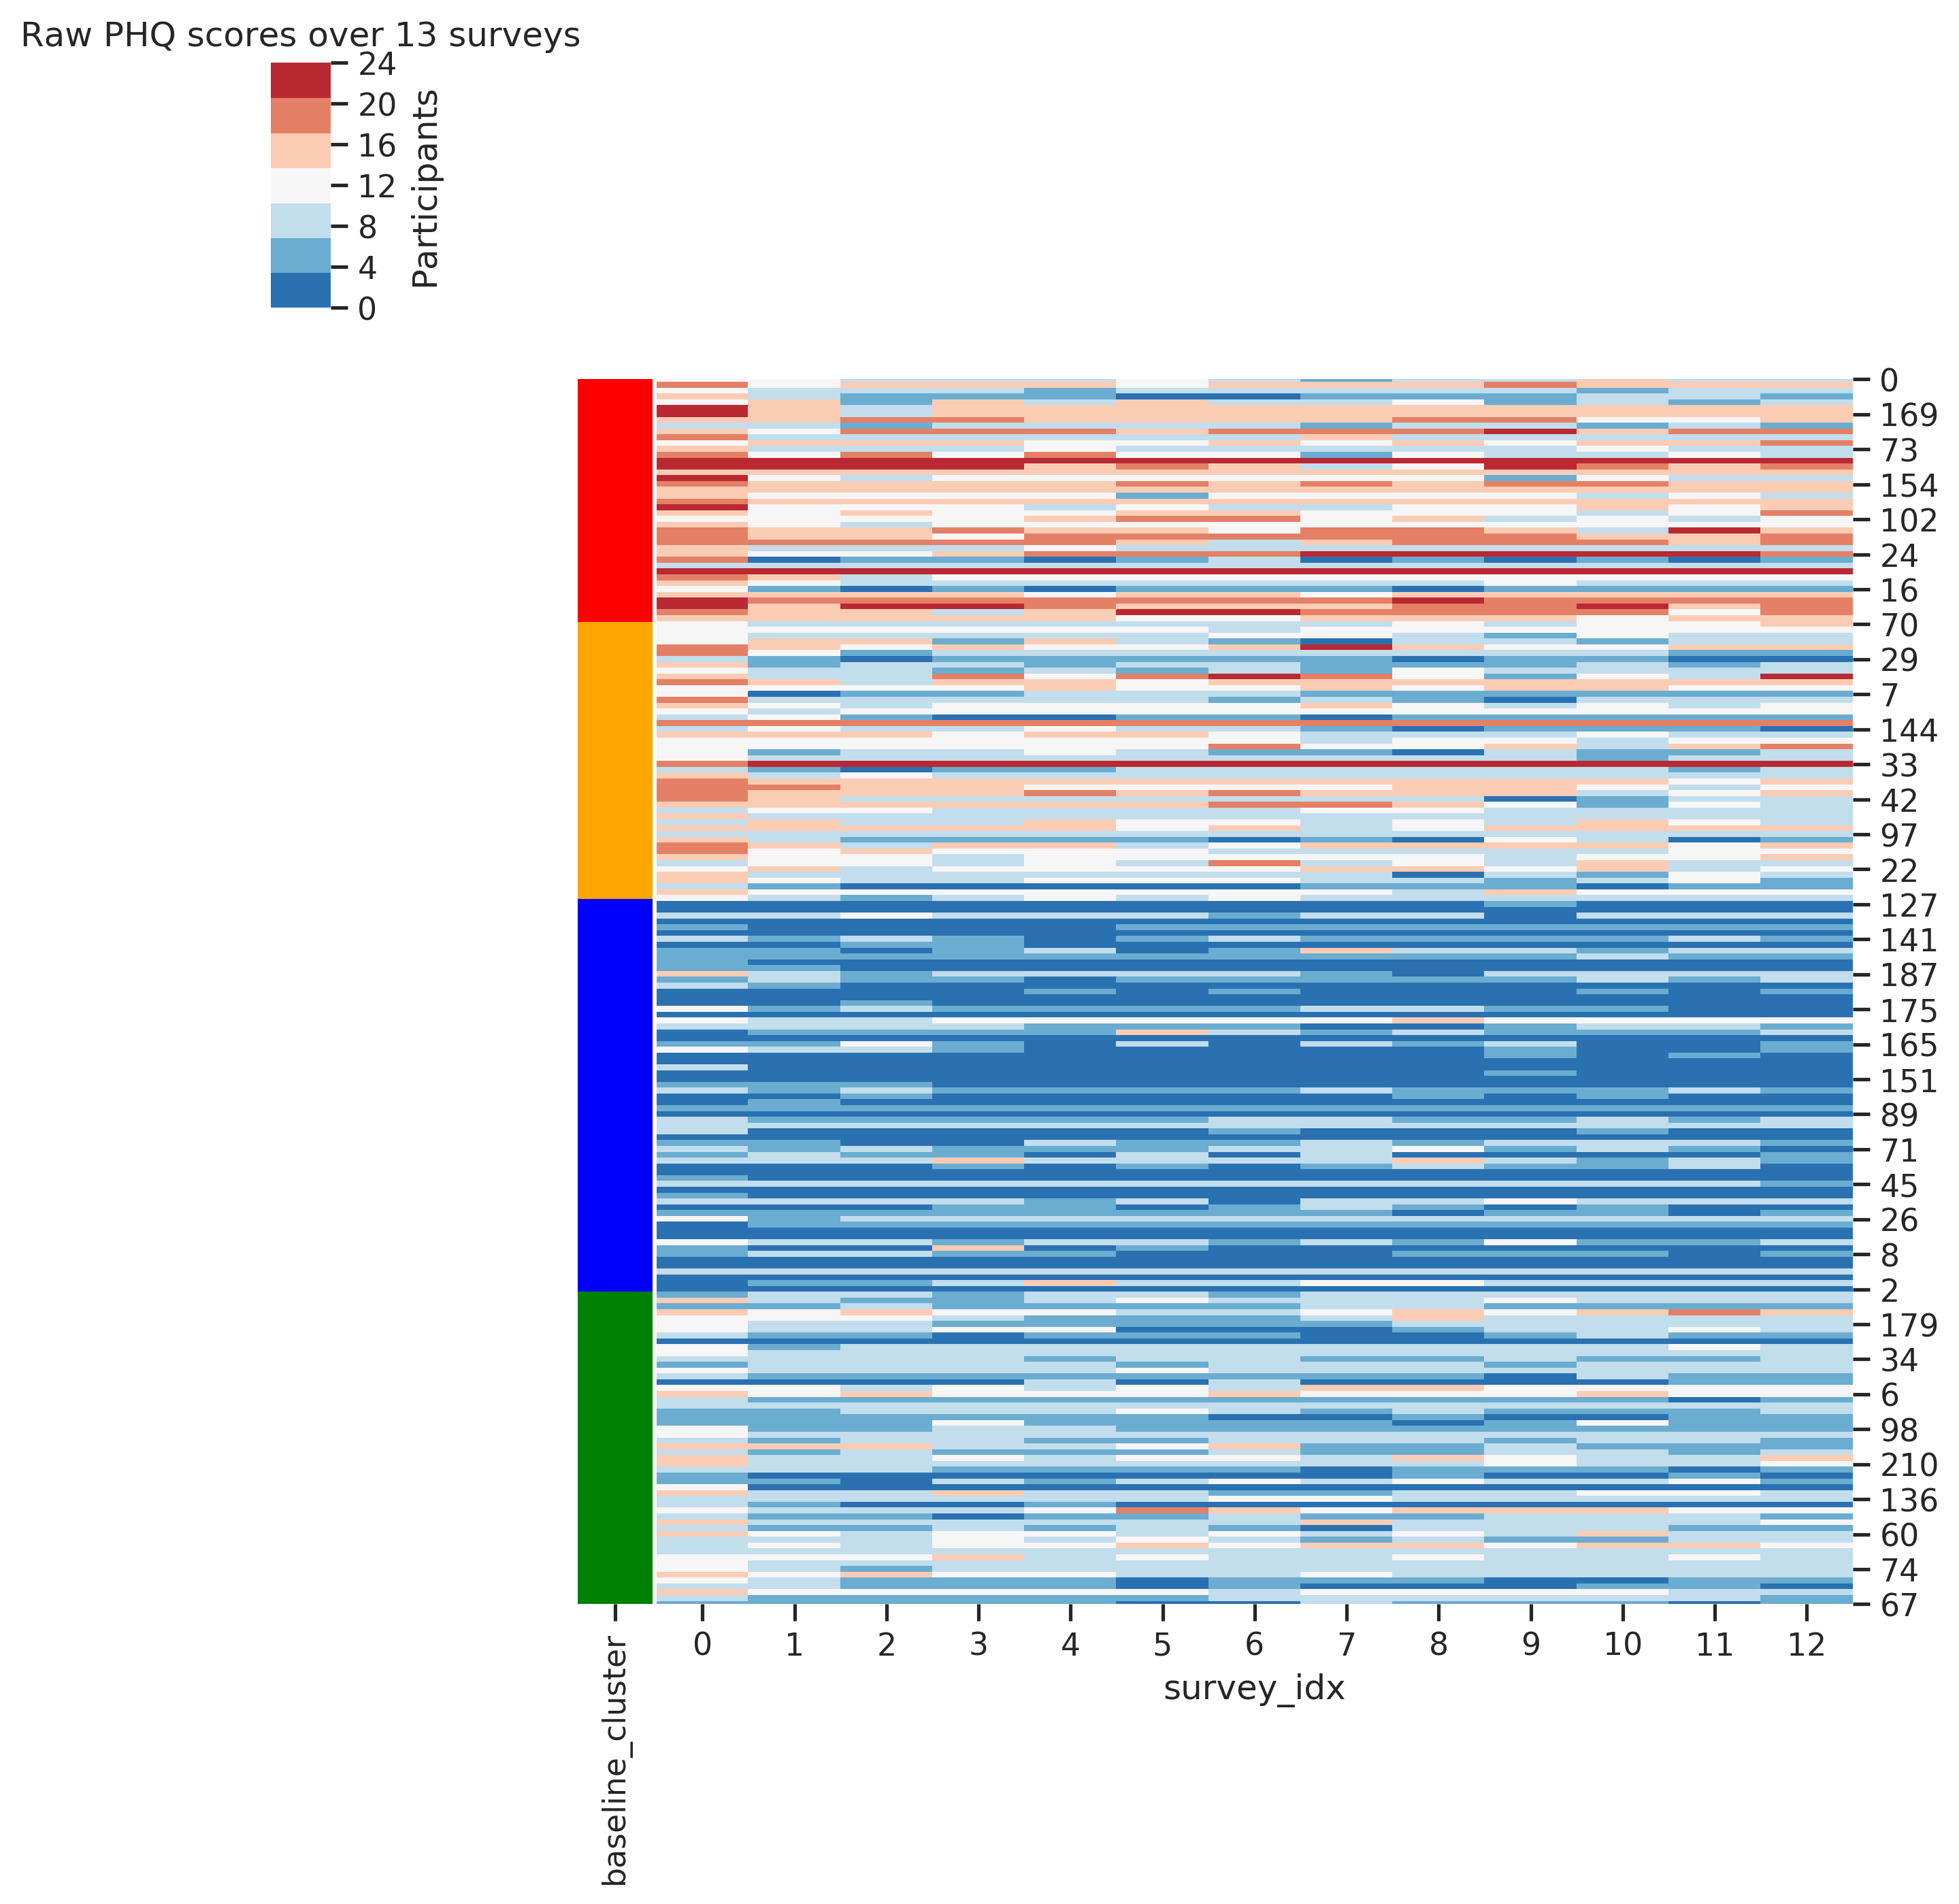

In [74]:
phq_pivot_cluster = phq_pivot.copy()
phq_pivot_cluster = phq_pivot_cluster.reset_index()
phq_pivot_cluster['baseline_cluster'] = phq_pivot_cluster['pid'].map(cluster_dict)
phq_pivot_cluster = phq_pivot_cluster.drop('pid', axis='columns')
phq_pivot_cluster = phq_pivot_cluster.sort_values(by=['baseline_cluster'])

cluster = phq_pivot_cluster.pop("baseline_cluster")
row_colors = cluster.map(color_map)
cmap = sns.color_palette("RdBu_r", 7)

sns.clustermap(phq_pivot_cluster['phq_tot'], cmap=cmap, figsize=(10,10), 
               col_cluster=False, row_cluster=False, row_colors=row_colors)
plt.ylabel("Participants")
plt.title("Raw PHQ scores over 13 surveys")
plt.show()

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


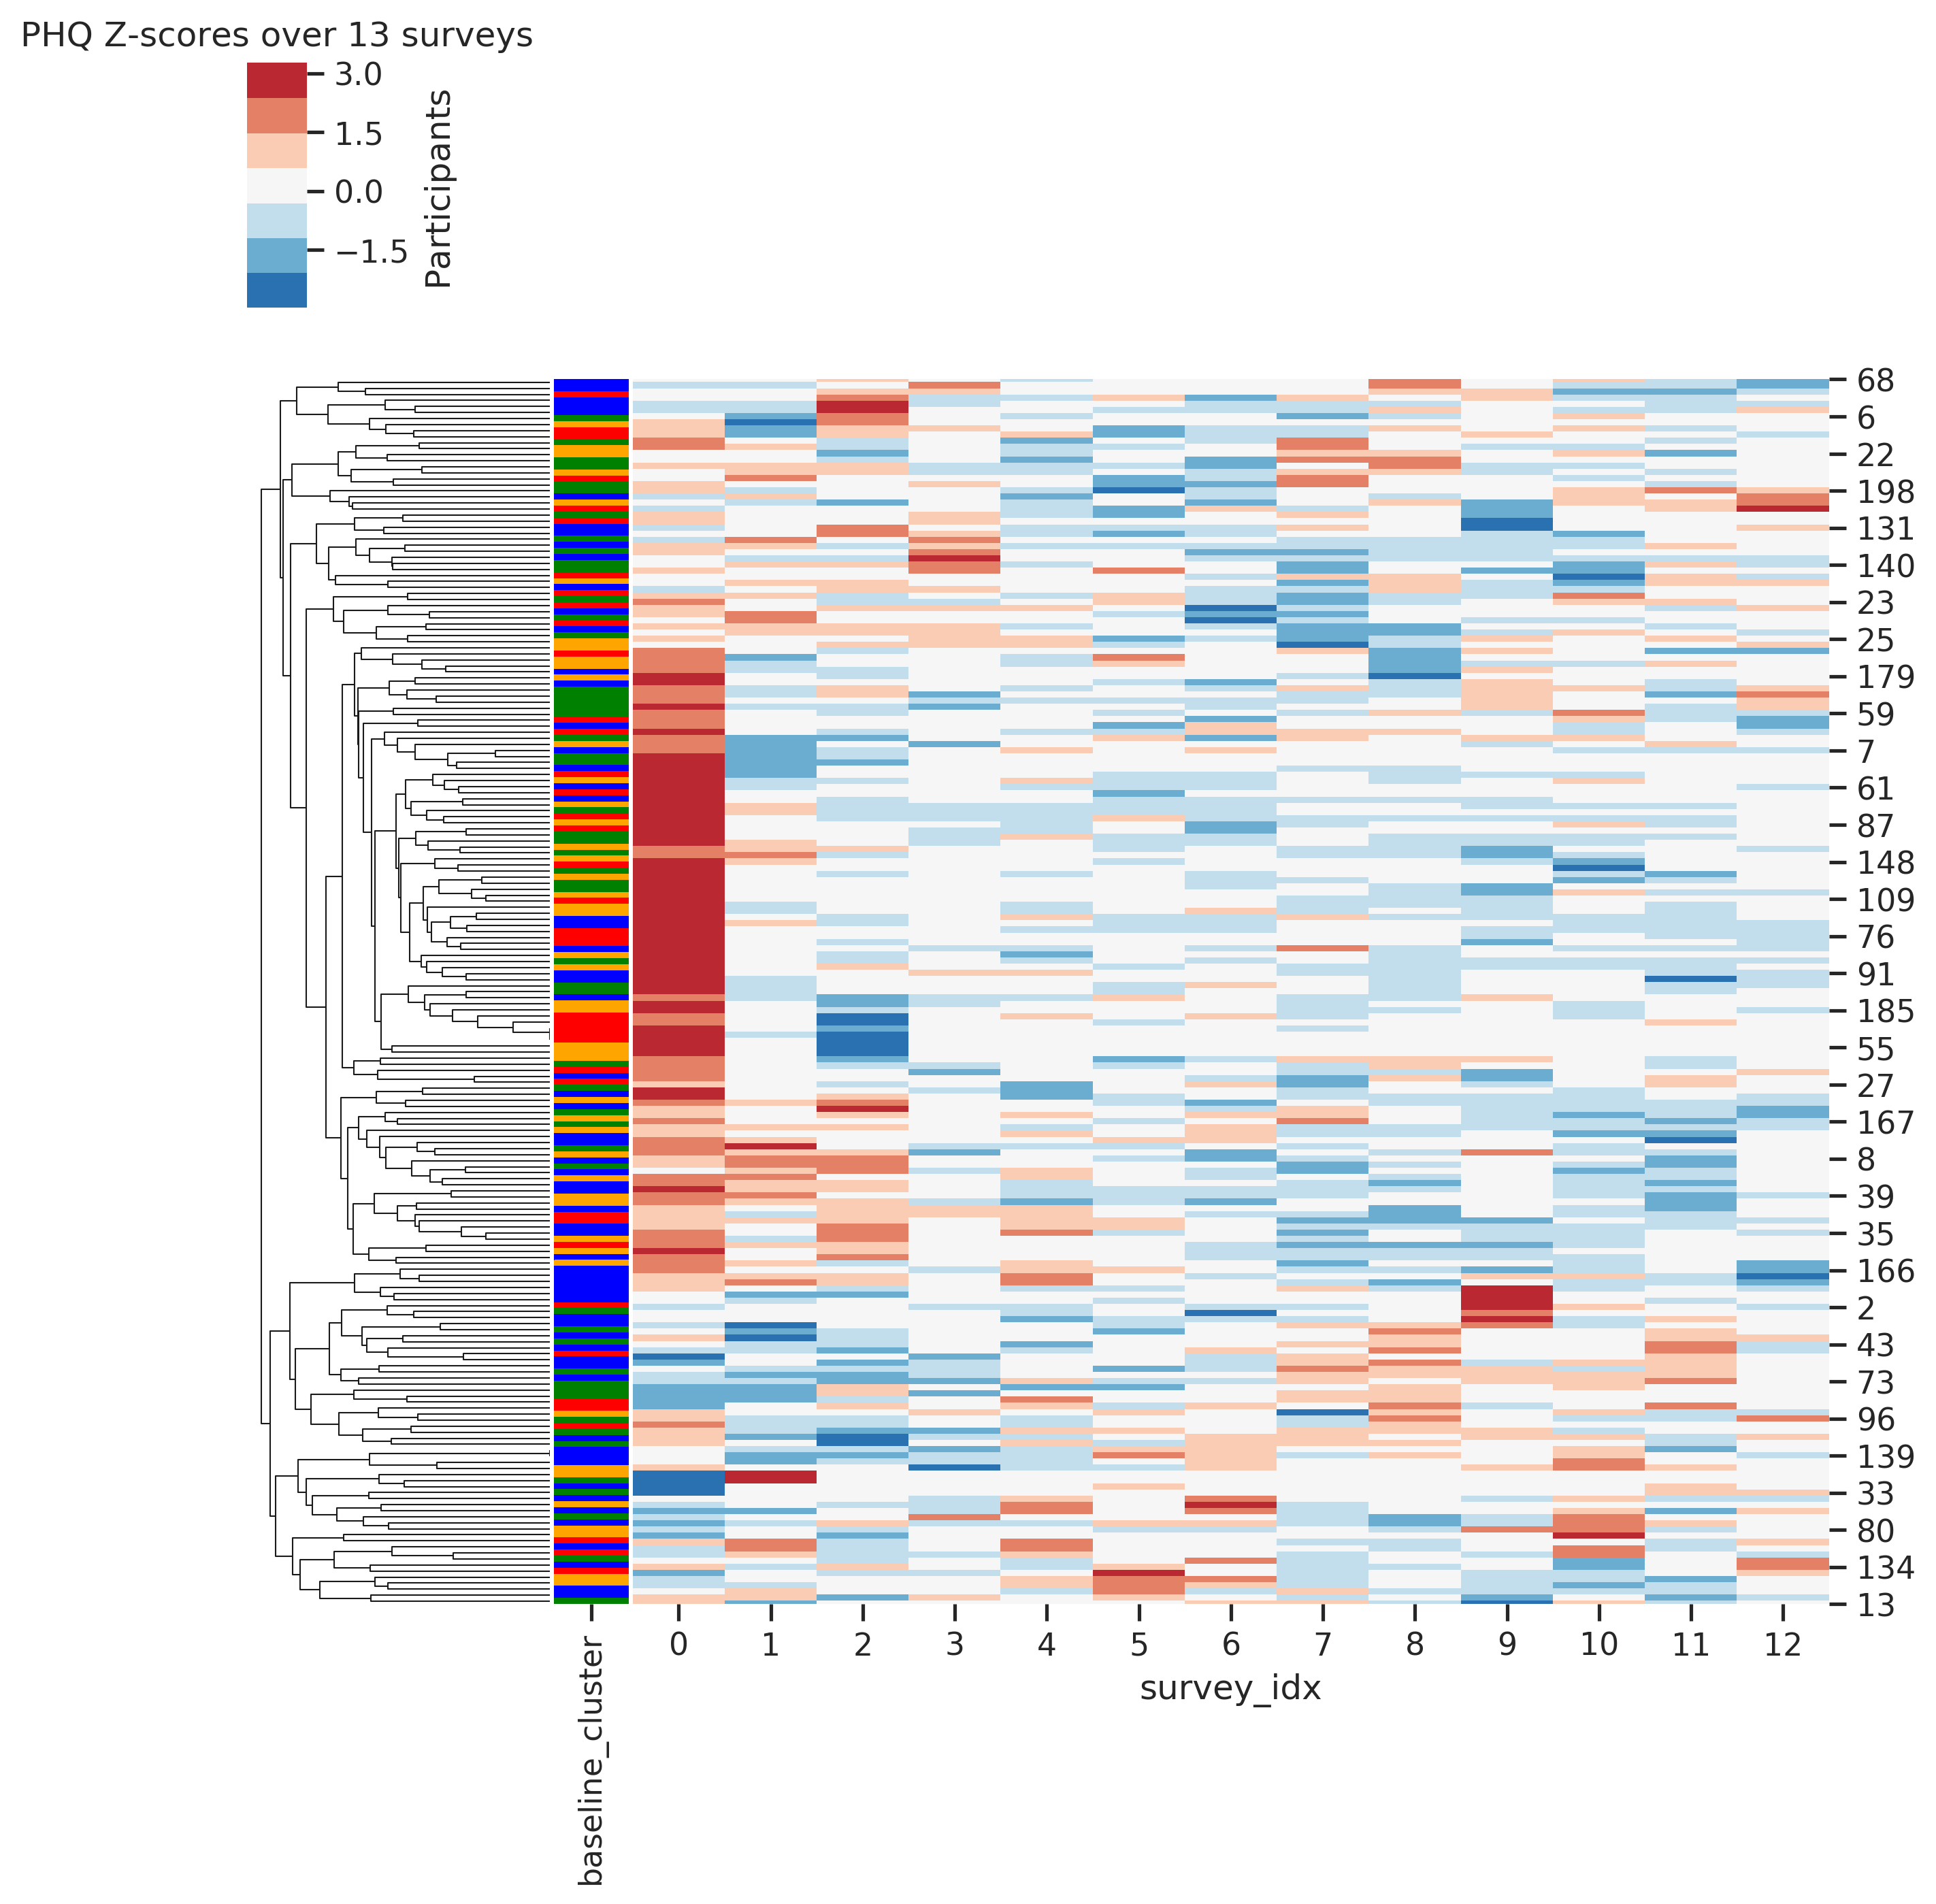

In [75]:
phq_pivot_z = phq_pivot.T
phq_pivot_z = ((phq_pivot_z - phq_pivot_z.mean())/phq_pivot_z.std()).T
phq_pivot_z = phq_pivot_z.dropna()

phq_pivot_z = phq_pivot_z.reset_index()
phq_pivot_z['baseline_cluster'] = phq_pivot_z['pid'].map(cluster_dict)
phq_pivot_z = phq_pivot_z.drop('pid', axis='columns')

cluster = phq_pivot_z.pop("baseline_cluster")
row_colors = cluster.map(color_map)
cmap = sns.color_palette("RdBu_r", 7)

sns.clustermap(phq_pivot_z['phq_tot'], cmap=cmap, figsize=(10,10), 
               col_cluster=False, row_colors=row_colors)
plt.ylabel("Participants")
plt.title("PHQ Z-scores over 13 surveys")
plt.show()

Text(0.5, 1.0, 'Within individual PHQ variance')

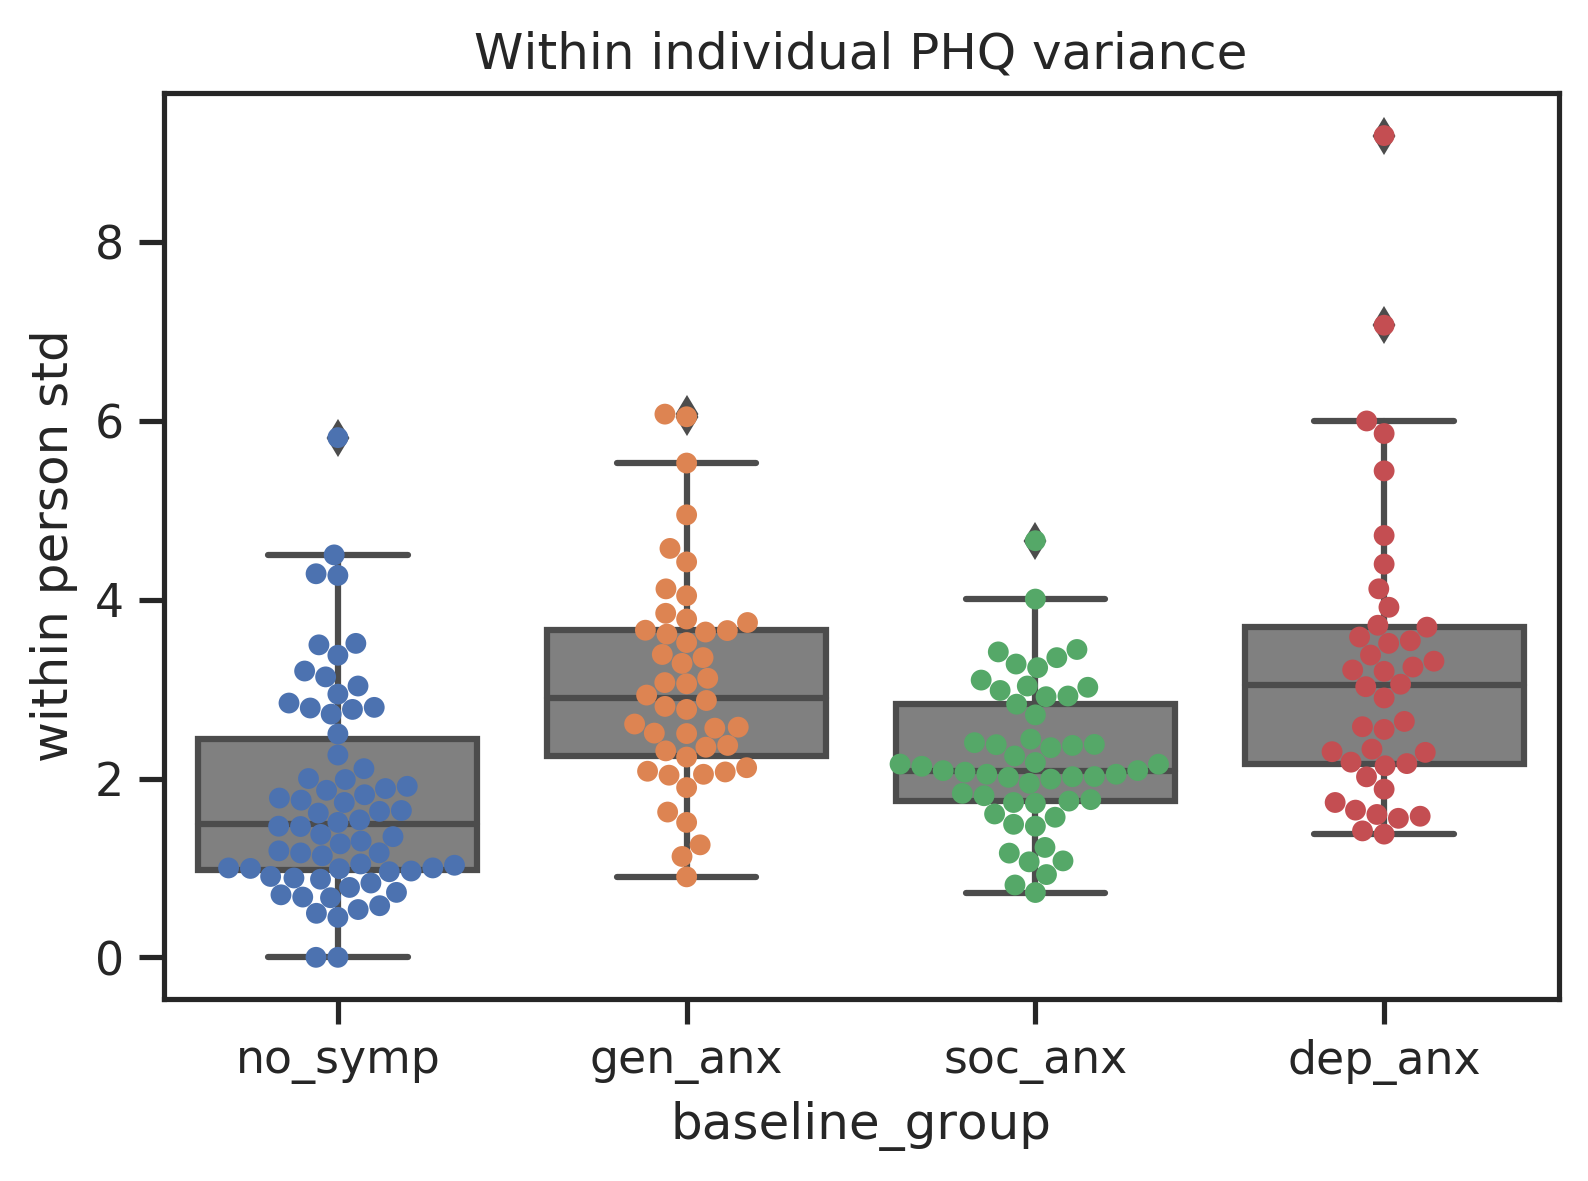

In [144]:
phq_std = phq_seq_df.groupby('pid')['phq_tot'].std()
phq_std = phq_std.to_frame().reset_index()
phq_std['baseline_group'] = phq_std['pid'].map(cluster_dict)
phq_std = phq_std.rename(columns={'phq_tot': 'within person std'})


ax = sns.swarmplot(x="baseline_group", y='within person std', data=phq_std,
                   #hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'])
                   order=['no_symp', 'gen_anx', 'soc_anx', 'dep_anx'])
ax = sns.boxplot(x="baseline_group", y='within person std', data=phq_std, 
                 #hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
                 order=['no_symp', 'gen_anx', 'soc_anx', 'dep_anx'], 
                 color=".5")
plt.title("Within individual PHQ variance")

Text(0.5, 1.0, 'Age across clusters')

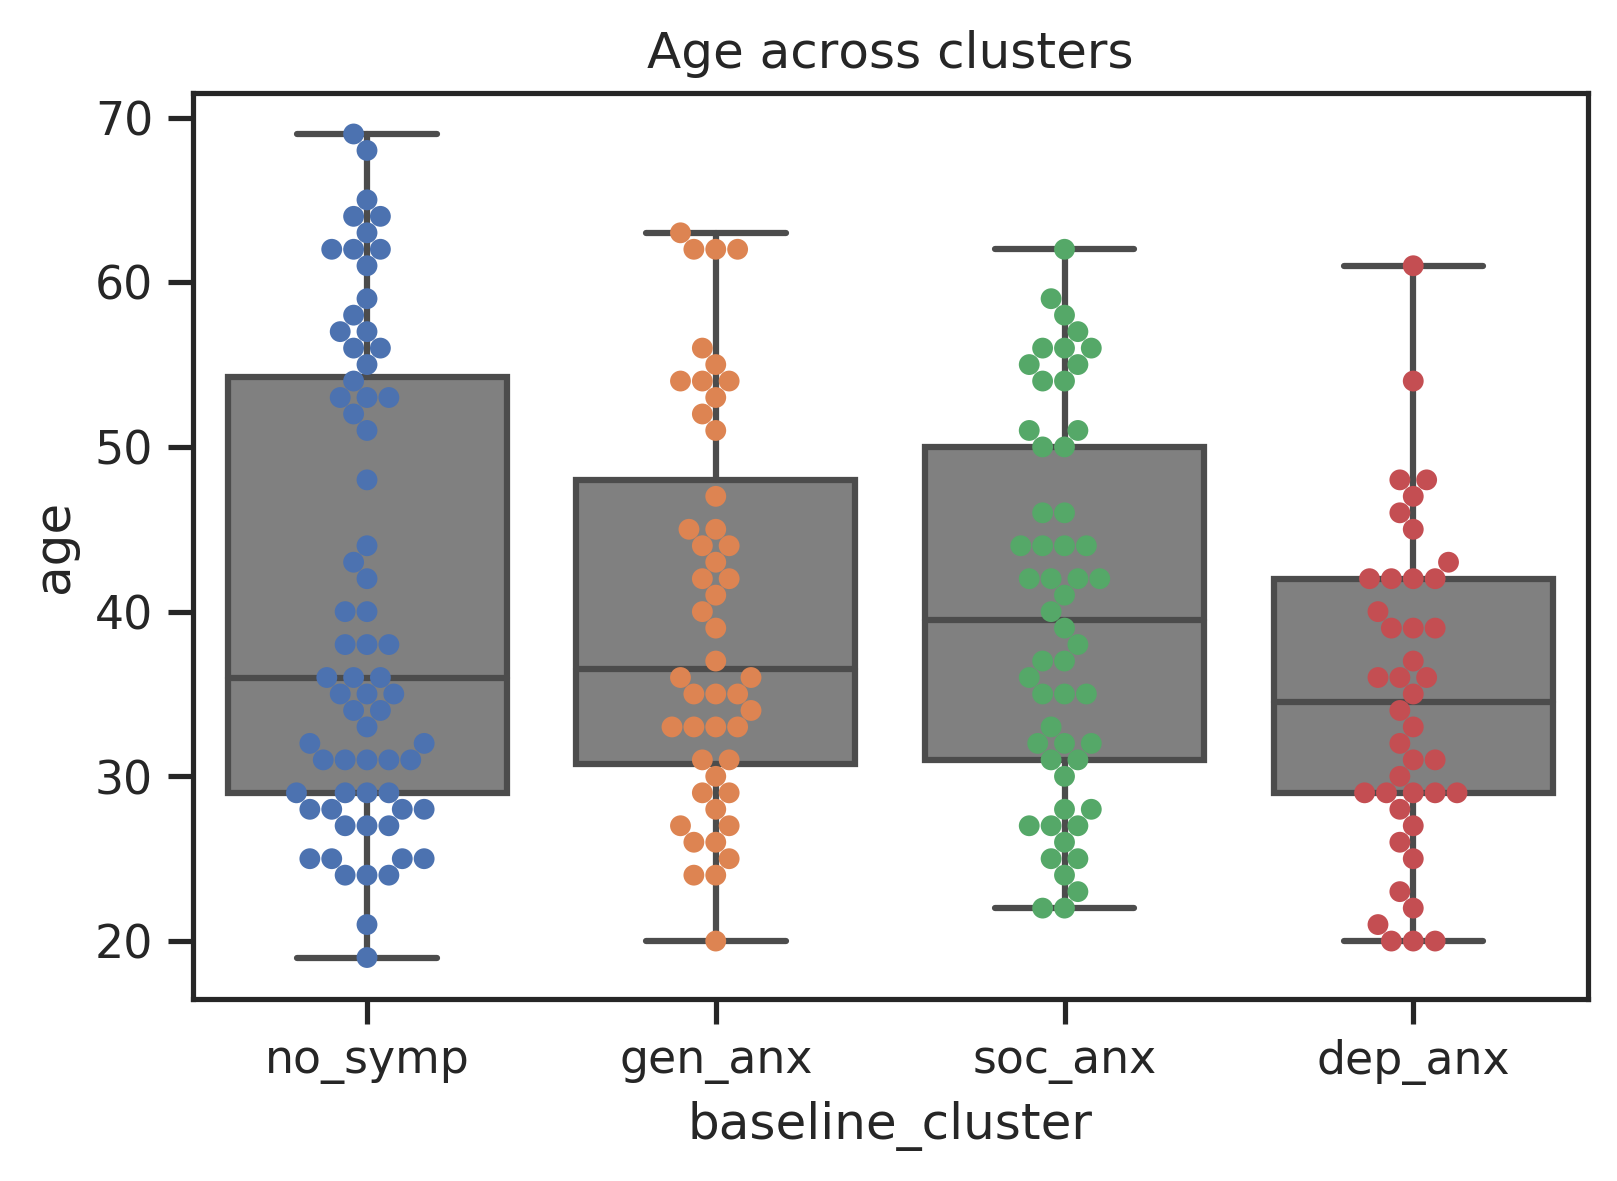

In [153]:
baseline_redcap_df['baseline_cluster'] = baseline_redcap_df['pid'].map(cluster_dict)

ax = sns.swarmplot(x="baseline_cluster", y='age', data=baseline_redcap_df,
                   #hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'])
                   order=['no_symp', 'gen_anx', 'soc_anx', 'dep_anx'])
ax = sns.boxplot(x="baseline_cluster", y='age', data=baseline_redcap_df, 
                 #hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
                 order=['no_symp', 'gen_anx', 'soc_anx', 'dep_anx'], 
                 color=".5")
plt.title("Age across clusters")

# Correlates Over Time

## Load data

In [82]:
# load cal data
all_cal = pd.read_pickle("ls_data/all_cal.df")
all_cal = all_cal.rename(columns={'call_hour': 'hour'})
all_cal.head()
all_cal = all_cal[(all_cal['hour'] < '2019-08-13') & (all_cal['hour'] >= '2019-07-20')]

wk4_cal = pd.read_pickle("ls_data/wk4/cal_hr.df")
wk7_cal = pd.read_pickle("ls_data/wk7/cal_hr.df")
wk10_cal = pd.read_pickle("ls_data/wk10/cal_hr.df")
wk13_cal = pd.read_pickle("ls_data/wk13/cal_hr.df")
wk16_cal = pd.read_pickle("ls_data/wk16/cal_hr.df")


all_cal = all_cal.append(wk4_cal)
all_cal = all_cal.append(wk7_cal)
all_cal = all_cal.append(wk10_cal)
all_cal = all_cal.append(wk13_cal)
all_cal = all_cal.append(wk16_cal)


# build cal_daily
all_cal['date'] = all_cal['hour'].dt.floor('d')
cal_daily = all_cal.groupby(['pid', 'date']).sum()
cal_daily = cal_daily.reset_index()
cal_daily["is_wkday"] = (pd.to_datetime(cal_daily['date']).dt.dayofweek < 5).astype(float)

display(cal_daily.head())

,pid,date,tot_call_count,tot_call_duration,is_wkday
0,00746649,2019-07-23,12,1814,1.0
1,00746649,2019-07-24,15,4572,1.0
2,00746649,2019-07-25,20,2363,1.0
3,00746649,2019-07-26,15,8063,1.0
4,00746649,2019-07-27,10,1748,0.0


In [83]:
# load sms data
all_sms = pd.read_pickle("ls_data/all_sms.df")
all_sms = all_sms.rename(columns={'sms_hour': 'hour'})
all_sms = all_sms[(all_sms['hour'] < '2019-08-13') & (all_sms['hour'] >= '2019-07-20')]

wk4_sms = pd.read_pickle("ls_data/wk4/sms_hr.df")
wk7_sms = pd.read_pickle("ls_data/wk7/sms_hr.df")
wk10_sms = pd.read_pickle("ls_data/wk10/sms_hr.df")
wk13_sms = pd.read_pickle("ls_data/wk13/sms_hr.df")
wk16_sms = pd.read_pickle("ls_data/wk16/sms_hr.df")

all_sms = all_sms.append(wk4_sms)
all_sms = all_sms.append(wk7_sms)
all_sms = all_sms.append(wk10_sms)
all_sms = all_sms.append(wk13_sms)
all_sms = all_sms.append(wk16_sms)

display(all_sms.head())

# build sms_daily
all_sms['date'] = all_sms['hour'].dt.floor('d')
sms_daily = all_sms.groupby(['pid', 'date']).sum()
sms_daily = sms_daily.reset_index()
sms_daily["is_wkday"] = (pd.to_datetime(sms_daily['date']).dt.dayofweek < 5).astype(float)

display(sms_daily.head())

,hour,tot_sms_count,tot_sms_length,in_sms_count,in_sms_length,out_sms_count,out_sms_length,pid
0,2019-07-27 21:00:00,6,192,4.0,105.0,2.0,87.0,08343773
1,2019-07-27 22:00:00,0,0,0.0,0.0,0.0,0.0,08343773
2,2019-07-27 23:00:00,0,0,0.0,0.0,0.0,0.0,08343773
3,2019-07-28 00:00:00,0,0,0.0,0.0,0.0,0.0,08343773
4,2019-07-28 01:00:00,0,0,0.0,0.0,0.0,0.0,08343773


,pid,date,tot_sms_count,tot_sms_length,in_sms_count,in_sms_length,out_sms_count,out_sms_length,is_wkday
0,00746649,2019-07-23,22,1738,22.0,1738.0,0.0,0.0,1.0
1,00746649,2019-07-24,24,1464,24.0,1464.0,0.0,0.0,1.0
2,00746649,2019-07-25,14,936,14.0,936.0,0.0,0.0,1.0
3,00746649,2019-07-26,23,2135,23.0,2135.0,0.0,0.0,1.0
4,00746649,2019-07-27,21,990,21.0,990.0,0.0,0.0,0.0


In [113]:
# load fga data
all_fga = pd.read_pickle("ls_data/all_fga.df")
all_fga = all_fga[(all_fga['hr'] < '2019-08-13') & (all_fga['hr'] >= '2019-07-20')]

wk4_fga = pd.read_pickle("ls_data/wk4/fga_hr.df")
wk7_fga = pd.read_pickle("ls_data/wk7/fga_hr.df")
wk10_fga = pd.read_pickle("ls_data/wk10/fga_hr.df")
wk13_fga = pd.read_pickle("ls_data/wk13/fga_hr.df")
wk16_fga = pd.read_pickle("ls_data/wk16/fga_hr.df")

all_fga = all_fga.append(wk4_fga)
all_fga = all_fga.append(wk7_fga)
all_fga = all_fga.append(wk10_fga)
all_fga = all_fga.append(wk13_fga)
all_fga = all_fga.append(wk16_fga)

display(all_fga.head())

# build fga_daily
all_fga['all_browser'] = all_fga['browser'] + all_fga['chrome']
all_fga['date'] = all_fga['hr'].dt.floor('d')
fga_daily = all_fga.groupby(['pid', 'date']).sum()
fga_daily = fga_daily.reset_index()
fga_daily["is_wkday"] = (pd.to_datetime(fga_daily['date']).dt.dayofweek < 5).astype(float)

display(fga_daily.head())

,hr,katana,orca,messaging,launcher,chrome,email,instagram,youtube,maps,snapchat,browser,pid
0,2019-07-27 12:00:00,1771.0,0.0,0.0,105.0,0.0,0.0,405.0,0.0,0.0,0.0,0.0,08343773
1,2019-07-27 13:00:00,1336.0,0.0,0.0,255.0,315.0,0.0,195.0,0.0,0.0,0.0,0.0,08343773
2,2019-07-27 14:00:00,1666.0,0.0,0.0,180.0,0.0,0.0,330.0,0.0,0.0,0.0,0.0,08343773
3,2019-07-27 15:00:00,1997.0,0.0,0.0,309.0,165.0,0.0,195.0,0.0,60.0,0.0,0.0,08343773
4,2019-07-27 16:00:00,1289.0,0.0,0.0,379.0,0.0,0.0,75.0,0.0,0.0,0.0,0.0,08343773


,pid,date,katana,orca,messaging,launcher,chrome,email,instagram,youtube,maps,snapchat,browser,all_browser,is_wkday
0,00746649,2019-07-23,0.0,0.0,3380.0,1753.0,1490.0,1113.0,211.0,1080.0,240.0,0.0,165.0,1655.0,1.0
1,00746649,2019-07-24,0.0,105.0,1888.0,2831.0,965.0,713.0,1203.0,0.0,0.0,0.0,931.0,1896.0,1.0
2,00746649,2019-07-25,0.0,135.0,5835.0,1826.0,98.0,770.0,368.0,0.0,73.0,0.0,509.0,607.0,1.0
3,00746649,2019-07-26,0.0,301.0,5288.0,1986.0,195.0,1362.0,842.0,0.0,1410.0,0.0,1065.0,1260.0,1.0
4,00746649,2019-07-27,0.0,0.0,3166.0,686.0,0.0,110.0,3310.0,0.0,847.0,0.0,0.0,0.0,0.0


In [85]:
# load fus data
all_fus = pd.read_pickle("ls_data/fus_daily.df")
display(all_fus.head())
all_fus = all_fus[(all_fus['date'] < '2019-08-13') & (all_fus['date'] >= '2019-07-20')]

wk4_fus = pd.read_pickle("ls_data/wk4/fus_daily.df")
wk7_fus = pd.read_pickle("ls_data/wk7/fus_daily.df")
wk10_fus = pd.read_pickle("ls_data/wk10/fus_daily.df")
wk13_fus = pd.read_pickle("ls_data/wk13/fus_daily.df")
wk16_fus = pd.read_pickle("ls_data/wk16/fus_daily.df")


all_fus = all_fus.append(wk4_fus)
all_fus = all_fus.append(wk7_fus)
all_fus = all_fus.append(wk10_fus)
all_fus = all_fus.append(wk13_fus)
all_fus = all_fus.append(wk16_fus)

display(all_fus.head())

# build fus_daily
fus_daily = all_fus.copy()
fus_daily["is_wkday"] = (pd.to_datetime(fus_daily['date']).dt.dayofweek < 5).astype(float)

,pid,date,dist,entropy,cluster,loc_var,velocity,norm_entropy,is_wkday
3,08343773,2019-07-30,85.911460,0.929294,3,-6.661614,5.252450,0.670344,1.0
4,08343773,2019-07-31,36.688011,0.692502,3,-6.661614,1.730937,0.499535,1.0
5,08343773,2019-08-01,29.716842,0.689384,3,-6.661614,1.890282,0.497286,1.0
6,08343773,2019-08-02,35.859320,0.187561,3,-6.661614,1.915279,0.135296,1.0
7,08343773,2019-08-03,18.821381,-0.000000,3,-6.661614,0.968159,-0.000000,0.0


/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,cluster,date,dist,entropy,is_wkday,loc_var,norm_entropy,pid,velocity
3,3,2019-07-30,85.911460,0.929294,1.0,-6.661614,0.670344,08343773,5.252450
4,3,2019-07-31,36.688011,0.692502,1.0,-6.661614,0.499535,08343773,1.730937
5,3,2019-08-01,29.716842,0.689384,1.0,-6.661614,0.497286,08343773,1.890282
6,3,2019-08-02,35.859320,0.187561,1.0,-6.661614,0.135296,08343773,1.915279
7,3,2019-08-03,18.821381,-0.000000,0.0,-6.661614,-0.000000,08343773,0.968159


In [86]:
# load circ data
all_circ = pd.read_pickle("ls_data/circ_movt.df")
display(all_circ.head())
#all_circ = all_circ[(all_circ['date'] < '2019-08-13') & (all_circ['date'] >= '2019-07-20')]
all_circ['wk_idx'] = 0

wk4_circ = pd.read_pickle("ls_data/wk4/circ_movt.df")
wk7_circ = pd.read_pickle("ls_data/wk7/circ_movt.df")
wk10_circ = pd.read_pickle("ls_data/wk10/circ_movt.df")
wk13_circ = pd.read_pickle("ls_data/wk13/circ_movt.df")
wk16_circ = pd.read_pickle("ls_data/wk16/circ_movt.df")

circ_dfs = [wk4_circ, 
            wk7_circ,
            wk10_circ,
            wk13_circ,
            wk16_circ]

for idx, df in enumerate(circ_dfs):
    df['wk_idx'] = idx+1
    all_circ = all_circ.append(df)

#all_circ = all_circ.append(wk4_circ)
#all_circ = all_circ.append(wk7_circ)
#all_circ = all_circ.append(wk10_circ)

display(all_circ.tail())

,pid,circ_movt_tot,circ_movt_wkday,circ_movt_wkend
0,08343773,1.309409,1.713618,2.383230
0,18583649,1.194895,1.529306,2.468502
0,99050875,1.933054,2.235061,3.232048
0,31456993,1.138472,1.522650,2.259386
0,01495950,1.544075,1.853465,2.851324


,pid,circ_movt_tot,circ_movt_wkday,circ_movt_wkend,wk_idx
0,73916801,2.747272,2.897326,4.783875,5
0,03233601,1.440295,1.749024,2.851877,5
0,62375942,1.175801,1.518448,2.448131,5
0,22352222,1.423715,1.772818,2.741219,5
0,21150752,1.302306,1.568057,2.788703,5


In [81]:
# load sloc data
all_sloc = pd.read_pickle("ls_data/all_sloc_hr.df")
print(all_sloc.columns.values)
all_sloc = all_sloc.rename(columns={'hr': 'hour'})
all_sloc.head()
all_sloc = all_sloc[(all_sloc['hour'] < '2019-08-13') & (all_sloc['hour'] >= '2019-07-20')]

wk4_sloc = pd.read_pickle("ls_data/wk4/sloc_hr.df")
wk7_sloc = pd.read_pickle("ls_data/wk7/sloc_hr.df")
wk10_sloc = pd.read_pickle("ls_data/wk10/sloc_hr.df")
wk13_sloc = pd.read_pickle("ls_data/wk13/sloc_hr.df")
wk16_sloc = pd.read_pickle("ls_data/wk16/sloc_hr.df")


all_sloc = all_sloc.append(wk4_sloc)
all_sloc = all_sloc.append(wk7_sloc)
all_sloc = all_sloc.append(wk10_sloc)
all_sloc = all_sloc.append(wk13_sloc)
all_sloc = all_sloc.append(wk16_sloc)


# build sloc_daily
all_sloc['date'] = all_sloc['hour'].dt.floor('d')
sloc_daily = all_sloc.groupby(['pid', 'date']).sum()
sloc_daily = sloc_daily.reset_index()
sloc_daily["is_wkday"] = (pd.to_datetime(sloc_daily['date']).dt.dayofweek < 5).astype(float)

display(sloc_daily.head())

['hr' 'food_dur' 'home_dur' 'work_dur' 'exercise_dur' 'anothers_home_dur'
 'religion_dur' 'travel_dur' 'other_dur' 'food_home' 'food_work'
 'food_exercise' 'food_anothers_home' 'food_religion' 'food_travel'
 'food_other' 'home_food' 'home_work' 'home_exercise' 'home_anothers_home'
 'home_religion' 'home_travel' 'home_other' 'work_food' 'work_home'
 'work_exercise' 'work_anothers_home' 'work_religion' 'work_travel'
 'work_other' 'exercise_food' 'exercise_home' 'exercise_work'
 'exercise_anothers_home' 'exercise_religion' 'exercise_travel'
 'exercise_other' 'anothers_home_food' 'anothers_home_home'
 'anothers_home_work' 'anothers_home_exercise' 'anothers_home_religion'
 'anothers_home_travel' 'anothers_home_other' 'religion_food'
 'religion_home' 'religion_work' 'religion_exercise'
 'religion_anothers_home' 'religion_travel' 'religion_other' 'travel_food'
 'travel_home' 'travel_work' 'travel_exercise' 'travel_anothers_home'
 'travel_religion' 'travel_other' 'other_food' 'other_home' 'oth

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,pid,date,anothers_home_dur,anothers_home_education,anothers_home_entertainment,anothers_home_errand,anothers_home_exercise,anothers_home_food,anothers_home_health,anothers_home_home,...,work_exercise,work_food,work_health,work_home,work_n/a,work_other,work_religion,work_shopping,work_travel,is_wkday
0,00746649,2019-07-23,0.0,0.0,0.0,0.0,0,0,0.0,0,...,0,0,0.0,0,0.0,0,0,0.0,0,1.0
1,00746649,2019-07-24,0.0,0.0,0.0,0.0,0,0,0.0,0,...,0,0,0.0,0,0.0,2,0,0.0,0,1.0
2,00746649,2019-07-25,0.0,0.0,0.0,0.0,0,0,0.0,0,...,0,0,0.0,0,0.0,0,0,0.0,0,1.0
3,00746649,2019-07-26,3726.0,0.0,0.0,0.0,0,0,0.0,0,...,0,0,0.0,0,0.0,0,0,0.0,0,1.0
4,00746649,2019-07-27,0.0,0.0,0.0,0.0,0,0,0.0,0,...,0,0,0.0,0,0.0,0,0,0.0,0,0.0


## Build Sequence DF

In [87]:
def build_col_dict(cols, feat_df, transform_log=True, pre_days=3, post_days=3):
    """Builds a (col, [vals]) dictionary for the given features
    
    Currently looks at a 7 day window around each survey
    """
    col_dict = {}


    for col in cols:
        col_dict[col] = []

    for idx, row in phq_seq_df.iterrows():
        if pd.isna(row['phq_tot']):
            for col in cols:
                col_dict[col].append(np.nan)
            continue
        else:
            date = row['date']
            pid = row['pid']
            sel_df =  feat_df[(feat_df['pid'] == pid) &
                              # TODO double check that this is the date range we want
                             (feat_df['date'] >= (date.floor('D') - pd.Timedelta(pre_days, unit='D'))) & 
                             (feat_df['date'] <= (date.floor('D') + pd.Timedelta(post_days, unit='D')))]
            sel_mean = sel_df.mean()
            
            if transform_log: sel_mean = np.log(sel_mean + 1)
            for col in cols:
                col_dict[col].append(sel_mean[col])
                
    return col_dict

# Correlation with next time steps

In [114]:
# columns
sms_cols = ['tot_sms_count', 'tot_sms_length', 'in_sms_count', 'in_sms_length', 'out_sms_count', 'out_sms_length']
cal_cols = ['tot_call_count', 'tot_call_duration']
fus_cols = ['cluster', 'dist', 'entropy', 'loc_var', 'norm_entropy', 'velocity']
fga_cols = ['katana', 'orca', 'messaging', 'launcher', 'email', 'instagram', 'youtube', 'maps', 'snapchat', 'all_browser']
sloc_cols = list(sloc_daily.columns[sloc_daily.columns.str.endswith('dur')])

## Digital Markers to State

In [115]:
%%time

sms_dict = build_col_dict(sms_cols, sms_daily, pre_days=7, post_days=-1)
cal_dict = build_col_dict(cal_cols, cal_daily, pre_days=7, post_days=-1)
fus_dict = build_col_dict(fus_cols, fus_daily, pre_days=7, post_days=-1)
fga_dict = build_col_dict(fga_cols, fga_daily, pre_days=7, post_days=-1)
sloc_dict = build_col_dict(sloc_cols, sloc_daily, pre_days=7, post_days=-1)

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in log


CPU times: user 59 s, sys: 169 ms, total: 59.1 s
Wall time: 57.8 s


In [116]:
dig_state_df = phq_seq_df.copy()

sensor_dicts = [sms_dict, cal_dict, fus_dict, fga_dict, sloc_dict]
sensor_cols = sms_cols + cal_cols + fus_cols + fga_cols + sloc_cols

for sensor_dict in sensor_dicts:
    for col, vals in sensor_dict.items():
        dig_state_df[col] = vals
    
dig_state_df = dig_state_df.replace([np.inf, -np.inf], np.nan)

dig_state_df.head()
dig_state_df = dig_state_df[dig_state_df['survey_idx'] != 0]

### Simple Correlation

#### Entire population

In [157]:
pair_corr_df = pg.pairwise_corr(dig_state_df, columns=[sensor_cols, ['phq_tot']], padjust="fdr_bh")
pair_corr_df[pair_corr_df['p-corr'] < 0.05][['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']]

,X,Y,n,r,p-corr,p-adjust
0,tot_sms_count,phq_tot,1738,-0.082,1.532647e-03,fdr_bh
1,tot_sms_length,phq_tot,1738,-0.060,2.238432e-02,fdr_bh
2,in_sms_count,phq_tot,1738,-0.066,1.315507e-02,fdr_bh
4,out_sms_count,phq_tot,1738,-0.120,2.233063e-06,fdr_bh
5,out_sms_length,phq_tot,1738,-0.095,2.249150e-04,fdr_bh
6,cluster,phq_tot,1644,-0.163,7.066878e-10,fdr_bh
7,dist,phq_tot,1644,-0.102,1.135735e-04,fdr_bh
8,entropy,phq_tot,1642,-0.147,2.365183e-08,fdr_bh
9,loc_var,phq_tot,329,-0.138,2.238432e-02,fdr_bh
15,orca,phq_tot,1797,0.133,9.967941e-08,fdr_bh


In [159]:
all_group_feats = pair_corr_df['X'].values

#### no_symp

In [118]:
sel_state_df = dig_state_df[dig_state_df['baseline_cluster'] == 'no_symp']
pair_corr_df = pg.pairwise_corr(sel_state_df, columns=[sensor_cols, ['phq_tot']], padjust="fdr_bh")
pair_corr_df[(pair_corr_df['p-corr'] < 0.05) & (pair_corr_df['n'] > 200)][['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']]

,X,Y,n,r,p-corr,p-adjust
0,tot_sms_count,phq_tot,555,-0.122,1.173359e-02,fdr_bh
2,in_sms_count,phq_tot,555,-0.141,3.120569e-03,fdr_bh
4,out_sms_count,phq_tot,555,-0.102,3.204759e-02,fdr_bh
8,cluster,phq_tot,524,-0.294,9.909431e-11,fdr_bh
9,dist,phq_tot,524,-0.220,2.728299e-06,fdr_bh
10,entropy,phq_tot,524,-0.344,1.612839e-14,fdr_bh
13,velocity,phq_tot,516,-0.226,2.044899e-06,fdr_bh
14,katana,phq_tot,575,0.133,4.759347e-03,fdr_bh
15,orca,phq_tot,575,0.168,2.554948e-04,fdr_bh
16,messaging,phq_tot,575,-0.166,2.666381e-04,fdr_bh


#### soc_anx

In [122]:
sel_state_df = dig_state_df[dig_state_df['baseline_cluster'] == 'soc_anx']
pair_corr_df = pg.pairwise_corr(sel_state_df, columns=[sensor_cols, ['phq_tot']], padjust="fdr_bh")
pair_corr_df[(pair_corr_df['p-corr'] < 0.05)][['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']]

,X,Y,n,r,p-corr,p-adjust
0,tot_sms_count,phq_tot,477,0.156,0.006212,fdr_bh
1,tot_sms_length,phq_tot,477,0.150,0.007305,fdr_bh
2,in_sms_count,phq_tot,477,0.159,0.006212,fdr_bh
3,in_sms_length,phq_tot,477,0.148,0.007305,fdr_bh
7,tot_call_duration,phq_tot,474,0.183,0.001757,fdr_bh
14,katana,phq_tot,479,-0.141,0.009868,fdr_bh
18,email,phq_tot,479,-0.132,0.015876,fdr_bh


#### gen_anx

In [124]:
sel_state_df = dig_state_df[dig_state_df['baseline_cluster'] == 'gen_anx']
pair_corr_df = pg.pairwise_corr(sel_state_df, columns=[sensor_cols, ['phq_tot']], padjust="fdr_bh")
pair_corr_df[(pair_corr_df['p-corr'] < 0.05)][['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']]

,X,Y,n,r,p-corr,p-adjust
14,katana,phq_tot,413,-0.157,0.010528,fdr_bh
15,orca,phq_tot,413,-0.197,0.000571,fdr_bh
19,instagram,phq_tot,413,-0.204,0.000426,fdr_bh
22,snapchat,phq_tot,413,-0.208,0.000426,fdr_bh


#### dep_anx

In [172]:
sel_state_df = dig_state_df[dig_state_df['baseline_cluster'] == 'dep_anx']
pair_corr_df = pg.pairwise_corr(sel_state_df, columns=[sensor_cols, ['phq_tot']], padjust="fdr_bh")
pair_corr_df[(pair_corr_df['p-corr'] < 0.05)][['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']]

,X,Y,n,r,p-corr,p-adjust
15,orca,phq_tot,330,0.228,0.000234,fdr_bh
19,instagram,phq_tot,330,0.147,0.038469,fdr_bh
21,maps,phq_tot,330,0.146,0.038469,fdr_bh
22,snapchat,phq_tot,330,0.294,0.000001,fdr_bh
23,all_browser,phq_tot,330,0.246,0.000074,fdr_bh


In [174]:
dep_anx_feat = pair_corr_df['X'].values

### Partial Correlation

In [164]:
def build_partial_corr(corr_df, target, covar, pval=0.05):
    """
    Builds partial correlation DataFrame from corr_df of the target survey, controlling for covar.
    """
    
    partial_corr = pg.pairwise_corr(data=corr_df, covar=[covar], method='pearson')
    partial_corr = partial_corr.loc[(partial_corr['p-unc'] < pval) & (partial_corr['X'].str.contains(target)) & (~partial_corr['Y'].str.contains(target))]
    partial_corr['r_ctl'] = partial_corr['r']
    partial_corr['p_ctl'] = partial_corr['p-unc']

    partial_corr = partial_corr[['X', 'Y', 'covar', 'r_ctl', 'p_ctl']]

    pairwise_corr = pg.pairwise_corr(data=corr_df, method='pearson')
    pairwise_corr['r_unctl'] = pairwise_corr['r']
    pairwise_corr['p_unctl'] = pairwise_corr['p-unc']

    partial_corr = partial_corr.merge(pairwise_corr[['X', 'Y', 'r_unctl', 'p_unctl']], on=['X', 'Y'], how='left')
    return partial_corr

In [156]:
dig_state_df['age'] = dig_state_df['pid'].map(age_dict)

#### All groups

In [165]:
build_partial_corr(dig_state_df, 'phq_tot', 'age')

,X,Y,covar,r_ctl,p_ctl,r_unctl,p_unctl
0,phq_tot,tot_sms_count,['age'],-0.104,1.400259e-05,-0.082,6.386027e-04
1,phq_tot,tot_sms_length,['age'],-0.079,9.726471e-04,-0.060,1.167994e-02
2,phq_tot,in_sms_count,['age'],-0.088,2.369961e-04,-0.066,6.029409e-03
3,phq_tot,in_sms_length,['age'],-0.058,1.613922e-02,-0.040,9.238305e-02
4,phq_tot,out_sms_count,['age'],-0.142,2.748486e-09,-0.120,5.582657e-07
5,phq_tot,out_sms_length,['age'],-0.113,2.222745e-06,-0.095,7.497166e-05
6,phq_tot,cluster,['age'],-0.179,2.681287e-13,-0.163,2.944532e-11
7,phq_tot,dist,['age'],-0.108,1.084205e-05,-0.102,3.312560e-05
8,phq_tot,entropy,['age'],-0.174,1.379103e-12,-0.147,1.970986e-09
9,phq_tot,loc_var,['age'],-0.143,9.193851e-03,-0.138,1.212484e-02


#### No symp

In [166]:
sel_state_df = dig_state_df[dig_state_df['baseline_cluster'] == 'no_symp']
build_partial_corr(sel_state_df, 'phq_tot', 'age')

,X,Y,covar,r_ctl,p_ctl,r_unctl,p_unctl
0,phq_tot,tot_sms_count,['age'],-0.106,1.218915e-02,-0.122,3.911196e-03
1,phq_tot,in_sms_count,['age'],-0.129,2.365866e-03,-0.141,8.321516e-04
2,phq_tot,out_sms_count,['age'],-0.085,4.641181e-02,-0.102,1.602380e-02
3,phq_tot,cluster,['age'],-0.291,1.168984e-11,-0.294,6.606288e-12
4,phq_tot,dist,['age'],-0.209,1.389610e-06,-0.220,3.637732e-07
5,phq_tot,entropy,['age'],-0.343,6.655913e-16,-0.344,5.376131e-16
6,phq_tot,loc_var,['age'],-0.207,1.201982e-02,-0.207,1.223849e-02
7,phq_tot,norm_entropy,['age'],-0.318,1.100913e-02,-0.339,6.512042e-03
8,phq_tot,velocity,['age'],-0.215,7.930332e-07,-0.226,2.044899e-07
9,phq_tot,katana,['age'],0.123,3.085420e-03,0.133,1.427804e-03


#### soc_anx

In [167]:
sel_state_df = dig_state_df[dig_state_df['baseline_cluster'] == 'soc_anx']
build_partial_corr(sel_state_df, 'phq_tot', 'age')

,X,Y,covar,r_ctl,p_ctl,r_unctl,p_unctl
0,phq_tot,tot_sms_count,['age'],0.154,0.000712,0.156,0.000621
1,phq_tot,tot_sms_length,['age'],0.148,0.001157,0.150,0.001014
2,phq_tot,in_sms_count,['age'],0.158,0.000524,0.159,0.000476
3,phq_tot,in_sms_length,['age'],0.147,0.001320,0.148,0.001217
4,phq_tot,tot_call_count,['age'],0.094,0.041459,0.094,0.041379
5,phq_tot,tot_call_duration,['age'],0.184,0.000055,0.183,0.000059
6,phq_tot,entropy,['age'],-0.119,0.012909,-0.109,0.022275
7,phq_tot,katana,['age'],-0.139,0.002232,-0.141,0.001974
8,phq_tot,email,['age'],-0.138,0.002471,-0.132,0.003704
9,phq_tot,instagram,['age'],0.108,0.017806,0.113,0.013536


#### gen_anx

In [168]:
sel_state_df = dig_state_df[dig_state_df['baseline_cluster'] == 'gen_anx']
build_partial_corr(sel_state_df, 'phq_tot', 'age')

,X,Y,covar,r_ctl,p_ctl,r_unctl,p_unctl
0,phq_tot,tot_call_count,['age'],0.120,0.015314,0.129,0.009260
1,phq_tot,tot_call_duration,['age'],0.116,0.018905,0.126,0.010926
2,phq_tot,loc_var,['age'],-0.312,0.021664,-0.232,0.091601
3,phq_tot,katana,['age'],-0.167,0.000659,-0.157,0.001404
4,phq_tot,orca,['age'],-0.186,0.000143,-0.197,0.000057
5,phq_tot,launcher,['age'],-0.124,0.011401,-0.124,0.011688
6,phq_tot,email,['age'],-0.121,0.013604,-0.106,0.030767
7,phq_tot,instagram,['age'],-0.188,0.000117,-0.204,0.000028
8,phq_tot,snapchat,['age'],-0.191,0.000091,-0.208,0.000021
9,phq_tot,exercise_dur,['age'],-0.272,0.022593,-0.240,0.045456


#### dep_anx

In [186]:
sel_state_df = dig_state_df[dig_state_df['baseline_cluster'] == 'dep_anx']
sel_state_df = sel_state_df[list(dep_anx_feat) + ['phq_tot', 'age']]
build_partial_corr(sel_state_df, 'phq_tot', 'age', pval=np.inf)

,covar,r_ctl,p_ctl,X,Y,r_unctl,p_unctl


### Repeated Measures Correlation

In [133]:
subset_sensors = sensor_cols = sms_cols + fus_cols + cal_cols + fga_cols #+ sloc_cols

def build_rmcorr_df(seq_df, cols, target='phq_tot'):
    rm_corr_df = pd.DataFrame()
    for col in cols:
        df = pg.rm_corr(data=seq_df, x=col, y=target, subject='pid')
        df['feat'] = col
        rm_corr_df = rm_corr_df.append(df)
        
    return rm_corr_df

#### All groups

In [134]:
rm_corr_df = build_rmcorr_df(dig_state_df, subset_sensors)
rm_corr_df[(rm_corr_df['pval'] < 0.05) & (rm_corr_df['feat'] != 'loc_var')]

,r,dof,pval,CI95%,power,feat
rm_corr,-0.080,1439,2.422446e-03,"[-0.13, -0.03]",0.859,cluster
rm_corr,-0.131,1439,5.604219e-07,"[-0.18, -0.08]",0.999,dist
rm_corr,-0.091,1437,5.771394e-04,"[-0.14, -0.04]",0.931,entropy
rm_corr,-0.104,1404,9.698860e-05,"[-0.16, -0.05]",0.974,velocity


#### no_symp

In [135]:
sel_state_df = dig_state_df[dig_state_df['baseline_cluster'] == 'no_symp']
rm_corr_df = build_rmcorr_df(sel_state_df, subset_sensors)
rm_corr_df[(rm_corr_df['pval'] < 0.05) & (rm_corr_df['feat'] != 'loc_var')]

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/pingouin/power.py:912: UserWarning: Sample size is too small to estimate power (n <= 4). Returning NaN.
  warnings.warn("Sample size is too small to estimate power "


,r,dof,pval,CI95%,power,feat
rm_corr,-0.132,457,0.004752,"[-0.22, -0.04]",0.808,entropy
rm_corr,-0.109,508,0.013812,"[-0.19, -0.02]",0.693,maps


#### soc_anx

In [136]:
sel_state_df = dig_state_df[dig_state_df['baseline_cluster'] == 'soc_anx']
rm_corr_df = build_rmcorr_df(sel_state_df, subset_sensors)
rm_corr_df[(rm_corr_df['pval'] < 0.05) & (rm_corr_df['feat'] != 'loc_var')]

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/pingouin/effsize.py:146: RuntimeWarning: divide by zero encountered in double_scalars
  se = 1 / np.sqrt(nx - 3)


,r,dof,pval,CI95%,power,feat
rm_corr,-0.179,384,0.000395,"[-0.27, -0.08]",0.945,dist
rm_corr,-0.113,374,0.027932,"[-0.21, -0.01]",0.596,velocity


#### gen_anx

In [137]:
sel_state_df = dig_state_df[dig_state_df['baseline_cluster'] == 'gen_anx']
rm_corr_df = build_rmcorr_df(sel_state_df, subset_sensors)
rm_corr_df[(rm_corr_df['pval'] < 0.05) & (rm_corr_df['feat'] != 'loc_var')]

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/pingouin/parametric.py:1658: RuntimeWarning: divide by zero encountered in double_scalars
  ms_w = ss_w / df_w
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/pingouin/effsize.py:146: RuntimeWarning: invalid value encountered in sqrt
  se = 1 / np.sqrt(nx - 3)


,r,dof,pval,CI95%,power,feat
rm_corr,-0.140,332,0.010197,"[-0.24, -0.03]",0.731,cluster
rm_corr,-0.163,332,0.002855,"[-0.27, -0.06]",0.849,dist
rm_corr,-0.165,320,0.002997,"[-0.27, -0.06]",0.845,velocity


#### dep_anx

In [138]:
sel_state_df = dig_state_df[dig_state_df['baseline_cluster'] == 'dep_anx']
rm_corr_df = build_rmcorr_df(sel_state_df, subset_sensors)
rm_corr_df[(rm_corr_df['pval'] < 0.05) & (rm_corr_df['feat'] != 'loc_var')]

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/pingouin/parametric.py:994: RuntimeWarning: divide by zero encountered in double_scalars
  fval = msbetween / mserror


AssertionError: 

## Fixed Effects Model

In [727]:
dig_state_df['zphq'] = dig_state_df.groupby("pid")['phq_tot'].apply(lambda x: (x - x.mean()) / x.std())


In [736]:
from linearmodels import PanelOLS

fe_data = dig_state_df.set_index(['pid', 'survey_idx'])
formula = """phq_tot ~ 1 + tot_sms_count + out_sms_count + out_sms_length + orca + messaging + launcher + chrome + browser + dist + entropy + EntityEffects"""
model = PanelOLS.from_formula(formula, data=fe_data)
print(model.fit(cov_type='robust'))

                          PanelOLS Estimation Summary                           
Dep. Variable:                phq_tot   R-squared:                        0.0282
Estimator:                   PanelOLS   R-squared (Between):             -0.0129
No. Observations:                2104   R-squared (Within):               0.0282
Date:                Tue, Dec 17 2019   R-squared (Overall):             -0.0077
Time:                        21:44:42   Log-likelihood                   -4795.8
Cov. Estimator:                Robust                                           
                                        F-statistic:                      5.3021
Entities:                         267   P-value                           0.0000
Avg Obs:                       7.8801   Distribution:                 F(10,1827)
Min Obs:                       1.0000                                           
Max Obs:                       11.000   F-statistic (robust):             4.7064
                            

In [733]:
formula = """zphq ~ 1 + dist + TimeEffects + EntityEffects"""
model = PanelOLS.from_formula(formula, data=fe_data)
print(model.fit(cov_type='robust'))

                          PanelOLS Estimation Summary                           
Dep. Variable:                   zphq   R-squared:                        0.0158
Estimator:                   PanelOLS   R-squared (Between):             -0.6208
No. Observations:                2135   R-squared (Within):               0.0159
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.0008
Time:                        21:38:35   Log-likelihood                   -2835.6
Cov. Estimator:                Robust                                           
                                        F-statistic:                      30.013
Entities:                         256   P-value                           0.0000
Avg Obs:                       8.3398   Distribution:                  F(1,1867)
Min Obs:                       1.0000                                           
Max Obs:                       11.000   F-statistic (robust):             28.931
                            

## Treatment Relationship to Digital Markers

In [782]:
def build_col_dict_general(cols, feat_df, target, seq_df, transform_log=True, pre_days=3, post_days=3):
    """Builds a (col, [vals]) dictionary for the given features
    
    Currently looks at a 7 day window around each survey
    """
    col_dict = {}


    for col in cols:
        col_dict[col] = []

    for idx, row in seq_df.iterrows():
        if pd.isna(row[target]):
            for col in cols:
                col_dict[col].append(np.nan)
            continue
        else:
            date = row['date']
            pid = row['pid']
            sel_df =  feat_df[(feat_df['pid'] == pid) &
                              # TODO double check that this is the date range we want
                             (feat_df['date'] >= (date.floor('D') - pd.Timedelta(pre_days, unit='D'))) & 
                             (feat_df['date'] <= (date.floor('D') + pd.Timedelta(post_days, unit='D')))]
            sel_mean = sel_df.mean()
            
            if transform_log: sel_mean = np.log(sel_mean + 1)
            for col in cols:
                col_dict[col].append(sel_mean[col])
                
    return col_dict

In [778]:
event_dict = {
   "week_0_arm_1": 0,
   "week_1_arm_1": 1,
   "week_4_arm_1": 2,
   "week_7_arm_1": 3,
   "week_10_arm_1": 4,
   "week_13_arm_1": 5,
   "week_16_arm_1": 6
}

state_df['study_wk'] = state_df['redcap_event_name'].map(event_dict)

last_phq_df = phq_df.drop_duplicates(subset=['pid', 'redcap_event_name'], keep='first')
last_phq_df['study_wk'] = last_phq_df['redcap_event_name'].map(event_dict)
all_state_df = state_df.merge(last_phq_df, on=['pid', 'study_wk', 'redcap_event_name'], how='left')

# replace 99s with nans, TODO better way to handle this?
all_state_df = all_state_df.replace(to_replace=99, value=np.nan)

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,pid,redcap_event_name,gad_start,gad01,gad02,gad03,gad04,gad05,gad06,gad07,...,phq02_sc,phq03_sc,phq04_sc,phq05_sc,phq06_sc,phq07_sc,phq08_sc,phq_total_sc,phq10_sc,phq_start
0,00746649,week_0_arm_1,2019-07-22,1.0,1.0,1.0,1.0,2.0,2.0,2.0,...,1,3,1,1,1,1,2,12.0,3,2019-07-22
1,00746649,week_4_arm_1,2019-08-23 19:04:16,3.0,3.0,3.0,3.0,3.0,3.0,2.0,...,2,2,2,0,1,1,0,9.0,2,2019-08-26 19:04:10
2,00746649,week_7_arm_1,2019-09-14 15:19:45,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,1,1,2,2,3,2,0,12.0,2,2019-09-10 14:28:31
3,00746649,week_10_arm_1,2019-10-04 16:25:27,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,1,1,1,0,1,1,0,6.0,1,2019-10-01 10:53:03
4,00746649,week_13_arm_1,2019-10-25 22:38:25,3.0,2.0,2.0,2.0,2.0,3.0,3.0,...,1,1,2,0,1,2,0,9.0,2,2019-10-22 13:02:22


In [791]:
treat_seq_df = all_state_df[['pid', 'study_wk', 'psytxhx_psychother_3wk', 'phq_total_sc', 'psytxhx_curr_meds_fu']]

treat_seq_df['date'] = all_state_df['txhx_start_fu']

treat_seq_df['date'] = pd.to_datetime(treat_seq_df['date'])

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [792]:
%%time

sms_dict = build_col_dict_general(sms_cols, sms_daily, 'psytxhx_curr_meds_fu', treat_seq_df, pre_days=14, post_days=-1)
cal_dict = build_col_dict_general(cal_cols, cal_daily, 'psytxhx_curr_meds_fu', treat_seq_df, pre_days=14, post_days=-1)
fus_dict = build_col_dict_general(fus_cols, fus_daily, 'psytxhx_curr_meds_fu', treat_seq_df, pre_days=14, post_days=-1)
fga_dict = build_col_dict_general(fga_cols, fga_daily, 'psytxhx_curr_meds_fu', treat_seq_df, pre_days=14, post_days=-1)

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in log


CPU times: user 33.2 s, sys: 40.1 ms, total: 33.3 s
Wall time: 33.3 s


In [795]:
dig_treat_df = treat_seq_df.copy()

sensor_dicts = [sms_dict, cal_dict, fus_dict, fga_dict]

for sensor_dict in sensor_dicts:
    for col, vals in sensor_dict.items():
        dig_treat_df[col] = vals
    
dig_treat_df = dig_treat_df.replace([np.inf, -np.inf], np.nan)

dig_treat_df.head()
dig_treat_df = dig_treat_df[dig_treat_df['study_wk'] != 0]

## Simple Correlations

In [797]:
pair_corr_df = pg.pairwise_corr(dig_treat_df, columns=[sensor_cols, ['psytxhx_psychother_3wk', 'psytxhx_curr_meds_fu']], padjust="fdr_bh")
pair_corr_df[pair_corr_df['p-corr'] < 0.01][['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']]

,X,Y,n,r,p-corr,p-adjust
29,instagram,psytxhx_curr_meds_fu,1292,-0.192,1.839496e-10,fdr_bh
31,youtube,psytxhx_curr_meds_fu,1292,-0.158,2.696404e-07,fdr_bh
36,browser,psytxhx_psychother_3wk,1289,-0.101,4.462703e-03,fdr_bh


## Repeated Measures Correlation

In [809]:
rm_corr_df = pd.DataFrame()
for col in sms_cols + fga_cols:
    df = pg.rm_corr(data=dig_treat_df, y='psytxhx_psychother_3wk', x=col, subject='pid')
    df['X'] = col
    df['Y'] = 'psytxhx_psychother_3wk'
    rm_corr_df = rm_corr_df.append(df)

In [810]:
rm_corr_df[(rm_corr_df['pval'] < 0.1) & (rm_corr_df['Y'] != 'loc_var')]

,r,dof,pval,CI95%,power,X,Y
rm_corr,0.055,1021,0.080826,"[-0.01, 0.12]",0.416,orca,psytxhx_psychother_3wk
rm_corr,0.052,1021,0.098899,"[-0.01, 0.11]",0.379,email,psytxhx_psychother_3wk
rm_corr,0.055,1021,0.077312,"[-0.01, 0.12]",0.424,maps,psytxhx_psychother_3wk


In [807]:
rm_corr_df = pd.DataFrame()
for col in sms_cols + fga_cols:
    df = pg.rm_corr(data=dig_treat_df, y='psytxhx_curr_meds_fu', x=col, subject='pid')
    df['X'] = col
    df['Y'] = 'psytxhx_curr_meds_fu'
    rm_corr_df = rm_corr_df.append(df)

In [808]:
rm_corr_df[(rm_corr_df['pval'] < 0.05) & (rm_corr_df['Y'] != 'loc_var')]

,r,dof,pval,CI95%,power,X,Y
rm_corr,-0.073,1024,0.02002,"[-0.13, -0.01]",0.643,browser,psytxhx_curr_meds_fu


## Panel Regression

In [812]:
fe_data = dig_treat_df.set_index(['pid', 'study_wk'])
formula = """psytxhx_curr_meds_fu ~ 1 + tot_sms_count + out_sms_count + out_sms_length + orca + messaging + launcher + chrome + browser + dist + entropy + EntityEffects"""
model = PanelOLS.from_formula(formula, data=fe_data)
print(model.fit(cov_type='robust'))

                           PanelOLS Estimation Summary                            
Dep. Variable:     psytxhx_curr_meds_fu   R-squared:                        0.0191
Estimator:                     PanelOLS   R-squared (Between):             -0.0025
No. Observations:                  1255   R-squared (Within):               0.0191
Date:                  Wed, Dec 18 2019   R-squared (Overall):             -0.0024
Time:                          07:55:41   Log-likelihood                    814.20
Cov. Estimator:                  Robust                                           
                                          F-statistic:                      1.9148
Entities:                           263   P-value                           0.0397
Avg Obs:                         4.7719   Distribution:                  F(10,982)
Min Obs:                         1.0000                                           
Max Obs:                         5.0000   F-statistic (robust):             1.1883
    

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/linearmodels/utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


In [813]:
fe_data = dig_treat_df.set_index(['pid', 'study_wk'])
formula = """psytxhx_psychother_3wk ~ 1 + tot_sms_count + out_sms_count + out_sms_length + orca + messaging + launcher + chrome + browser + dist + entropy + EntityEffects"""
model = PanelOLS.from_formula(formula, data=fe_data)
print(model.fit(cov_type='robust'))

                            PanelOLS Estimation Summary                             
Dep. Variable:     psytxhx_psychother_3wk   R-squared:                        0.0083
Estimator:                       PanelOLS   R-squared (Between):             -0.0158
No. Observations:                    1252   R-squared (Within):               0.0083
Date:                    Wed, Dec 18 2019   R-squared (Overall):             -0.0105
Time:                            07:56:36   Log-likelihood                    115.13
Cov. Estimator:                    Robust                                           
                                            F-statistic:                      0.8184
Entities:                             263   P-value                           0.6109
Avg Obs:                           4.7605   Distribution:                  F(10,979)
Min Obs:                           1.0000                                           
Max Obs:                           5.0000   F-statistic (robust):

## State to Digital Markers

In [703]:
%%time

sms_dict = build_col_dict(sms_cols, sms_daily, pre_days=-1, post_days=7)
cal_dict = build_col_dict(cal_cols, cal_daily, pre_days=-1, post_days=7)
fus_dict = build_col_dict(fus_cols, fus_daily, pre_days=-1, post_days=7)
fga_dict = build_col_dict(fga_cols, fga_daily, pre_days=-1, post_days=7)

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in log


CPU times: user 58.1 s, sys: 53.7 ms, total: 58.2 s
Wall time: 58.2 s


In [704]:
state_dig_df = phq_seq_df.copy()

sensor_dicts = [sms_dict, cal_dict, fus_dict, fga_dict]

for sensor_dict in sensor_dicts:
    for col, vals in sensor_dict.items():
        state_dig_df[col] = vals
    
state_dig_df = state_dig_df.replace([np.inf, -np.inf], np.nan)

state_dig_df.head()
state_dig_df = state_dig_df[state_dig_df['survey_idx'] != 0]

### Simple Correlation

In [708]:
pair_corr_df = pg.pairwise_corr(state_dig_df, columns=[['phq_tot'], sensor_cols], padjust="fdr_bh")
pair_corr_df[pair_corr_df['p-corr'] < 0.01][['X', 'Y', 'n', 'r', 'p-corr', 'p-adjust']]

,X,Y,n,r,p-corr,p-adjust
0,phq_tot,tot_sms_count,2291,-0.098,8.552909e-06,fdr_bh
1,phq_tot,tot_sms_length,2291,-0.075,6.895980e-04,fdr_bh
2,phq_tot,in_sms_count,2291,-0.077,5.264496e-04,fdr_bh
3,phq_tot,in_sms_length,2291,-0.062,5.671399e-03,fdr_bh
4,phq_tot,out_sms_count,2291,-0.144,1.264362e-10,fdr_bh
5,phq_tot,out_sms_length,2291,-0.109,6.908906e-07,fdr_bh
9,phq_tot,orca,2369,0.091,3.029036e-05,fdr_bh
10,phq_tot,messaging,2369,-0.111,3.304393e-07,fdr_bh
11,phq_tot,launcher,2368,-0.074,6.895980e-04,fdr_bh
12,phq_tot,chrome,2369,0.114,2.214918e-07,fdr_bh


### Repeated Measures Correlation

In [711]:
rm_corr_df = pd.DataFrame()
for col in sensor_cols:
    df = pg.rm_corr(data=state_dig_df, x='phq_tot', y=col, subject='pid')
    df['X'] = 'phq_tot'
    df['Y'] = col
    rm_corr_df = rm_corr_df.append(df)

In [714]:
rm_corr_df[(rm_corr_df['pval'] < 0.01) & (rm_corr_df['Y'] != 'loc_var')]

,r,dof,pval,CI95%,power,X,Y
rm_corr,-0.073,2076,0.000811,"[-0.12, -0.03]",0.918,phq_tot,cluster


## Sandbox

In [737]:
def get_circadian_movement(fus_df):
    """Calculates the circadian movement based on GPS location for participants
    
    TODO need to verify the frequency is calculated correctly.
    
    """
    freq = np.linspace(86400-30*60, 86400+30*60, 2*30*60)
    try:
        energy_lat = sum(lombscargle(fus_df['timestamp'], fus_df['latitude'], freq, normalize=True))
        energy_long = sum(lombscargle(fus_df['timestamp'], fus_df['longitude'], freq, normalize=True))
    except ZeroDivisionError:
        return np.nan
    
    tot_energy = energy_lat + energy_long
    if tot_energy > 0:
        return np.log(energy_lat + energy_long)
    else:
        return np.nan

2.0156343842773152

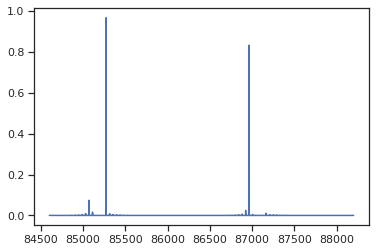

In [819]:
freq = np.linspace(86400-30*60, 86400+30*60, 2*30*60)
x = np.linspace(0, 100*(86400+30*60), 2*30*60)
phi = 86400

y = np.sin(0.001*phi*x)
pgram = lombscargle(x, y, freq, normalize=True)
plt.plot(freq, pgram)
sum(pgram)

# TODOs

- ~~correlations with baseline/week 10 readings~~
- correlations with transitions, within person ("categorical histogram" here?)
- load scr df
- ~~within person correlations with error bars (not over time)~~